## 1. Importar Librerias

In [1]:
#pip install rapidfuzz

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from matplotlib import cm
import random
import glob
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
import joblib
import re
import unicodedata

from rapidfuzz import fuzz, process #limpieza datos
from itertools import combinations
from collections import Counter
from scipy.sparse import csr_matrix, coo_matrix

import unidecode
def remove_accents(a):
    return unidecode.unidecode(a)

##  2. Carga y Procesamiento de Datos

En este proceso, se cargaran bases de licitaciones públicas en Chile entre los años 2014-2018.Para esto, se utilizará las licitaciones, la base de sectores para identificar a que sector pertenece la empresa (municipalidad, salud, etc) y por último la base de rubros que nos dará más información sobre la categoría del producto.  

### 2.1 Cargar licitaciones

In [3]:
# Definir la ruta donde se encuentran los archivos de licitaciones
path = 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod'  # Cambia esto si tus archivos están en otra carpeta

# Definir el patrón de archivos
pattern = 'licitaciones_*.csv'

# Usar glob para obtener la lista de archivos que coinciden con el patrón
all_files = glob.glob(os.path.join(path, pattern))

# Verificar los archivos encontrados
print(f"Archivos encontrados: {all_files}")

Archivos encontrados: ['C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2014.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2015.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2016.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2017.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2018.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2019.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2020.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2021.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod\\licitaciones_2022.csv', 'C:/Users/chaco/OneDrive/Escritorio/Magis

In [4]:
# Lista para almacenar cada DataFrame anual
list_of_dfs = []

for file in all_files:
    # Extraer el año del nombre del archivo
    basename = os.path.basename(file)  # Ejemplo: 'licitaciones_2014.csv'
    year = basename.split('_')[1].split('.')[0]
    
    # Leer el archivo CSV
    df = pd.read_csv(file, sep=',', encoding='latin-1', decimal='.')
    
    # Añadir una columna para el año
    df['Año'] = int(year)
    
    # Agregar el DataFrame a la lista
    list_of_dfs.append(df)

# Concatenar todos los DataFrames en uno solo
lic_all_years = pd.concat(list_of_dfs, ignore_index=True)

# Verificar la concatenación
print(f"Total de registros combinados: {lic_all_years.shape[0]}")

Total de registros combinados: 32842361


### 2.2 Fusión con sectores

In [5]:
ruta='C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod'
archivos_en_ruta=os.listdir(ruta)
print(archivos_en_ruta)

['CAPSTONE PROJECT FINAL.ipynb', 'CAPSTONE PROJECT MATI.ipynb', 'CAPSTONE PROJECT.ipynb', 'Cod_nuevo.ipynb', 'Cod_ricky copy 2.ipynb', 'Cod_ricky.ipynb', 'comparison_table.csv', 'comunidades_detectadas.csv', 'datos_licitaciones.ipynb', 'Demás licitaciones', 'density_data.parquet', 'density_relatedness_results.csv', 'df.csv', 'df_density_relatedness.csv', 'df_merged.csv', 'df_metricas_comunidad.csv', 'especializacion_df.csv', 'feature_importance.csv', 'GrafoProximidadRubros.gexf', 'grafo_proximidad.gexf', 'licitaciones_2014.csv', 'licitaciones_2015.csv', 'licitaciones_2016.csv', 'licitaciones_2017.csv', 'licitaciones_2018.csv', 'licitaciones_2019.csv', 'licitaciones_2020.csv', 'licitaciones_2021.csv', 'licitaciones_2022.csv', 'licitaciones_2023.csv', 'lic_all_years_clean.csv', 'lic_combinadas_2014_2018.csv', 'lic_combinadas_2014_2023.csv', 'ListadoProveedoresVigentes-12-11-2024.pdf', 'matriz_especializacion.csv', 'matriz_especializacion.png', 'matriz_proximidad.csv', 'metrics_df.csv', '

In [6]:
archivo=os.path.join(ruta,'sectores.csv')
try:
    sectores=pd.read_csv(archivo,sep=";")
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"El archivo '{archivo}'no se encuentra")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

Archivo cargado correctamente.


In [7]:
# Asegurarse de que las columnas clave están en el mismo formato
lic_all_years['NombreOrganismo'] = lic_all_years['NombreOrganismo'].astype(str).str.strip()
sectores['Nombre de la institución'] = sectores['Nombre de la institución'].astype(str).str.strip()

# Fusionar con sector 
lic_all_years = pd.merge(
    lic_all_years,
    sectores[['Nombre de la institución','Sector']],
    how='left',
    left_on="NombreOrganismo",
    right_on='Nombre de la institución'
)

lic_all_years.drop(columns=["Nombre de la institución"],inplace=True)

### 2.3 Fusión con Rubros


In [8]:
archivo=os.path.join(ruta,'rubros_onu.xlsx')
try:
    rubros_onu=pd.read_excel(archivo)
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"El archivo '{archivo}'no se encuentra")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

Archivo cargado correctamente.


In [9]:
# Asegurarse de que las columnas clave están en el mismo formato
lic_all_years['CodigoProductoONU'] = lic_all_years['CodigoProductoONU'].astype(str).str.strip()
rubros_onu['CodigoProductoONU'] = rubros_onu['CodigoProductoONU'].astype(str).str.strip()

# Fusionar con rubros ONU
lic_all_years = pd.merge(
    lic_all_years,
    rubros_onu[['CodigoProductoONU','NombreProducto','RubroN2']],
    how='left',
    on='CodigoProductoONU'
)

### 2.4 Guardar y Cargar Data Unificada (2014-2023)

In [10]:
#ruta = 'C:/Users/SCL_SERVIDOR/Desktop/Capstone Project/lic_combinadas_2014_2018.csv'
#lic_all_years.to_csv(ruta, index=False, encoding='utf-8-sig')

In [2]:
lic_all_years = pd.read_csv('lic_combinadas_2014_2023.csv')

C:\Users\chaco\AppData\Local\Temp\ipykernel_25604\2980668233.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  lic_all_years = pd.read_csv('lic_combinadas_2014_2023.csv')


In [3]:
lic_all_years.head()

,Codigo,Tipo de Adquisicion,NombreOrganismo,FechaPublicacion,CodigoProductoONU,NombreProveedor,Moneda de la Oferta,MontoUnitarioOferta,CantidadAdjudicada,MontoLineaAdjudica,Oferta seleccionada,Año,Sector,NombreProducto,RubroN2
0,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Brújula Consultoría Turística,Peso Chileno,380000000.0,1.0,380000000.0,Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
1,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,LORENA ANGELICA,Peso Chileno,389400000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
2,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Murillo y Partners,Peso Chileno,389400000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
3,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Universidad San Sebastián,Peso Chileno,389400000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
4,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Centro Trapananda,Peso Chileno,384100000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos


In [6]:
lic_all_years

,Codigo,Tipo de Adquisicion,NombreOrganismo,FechaPublicacion,CodigoProductoONU,NombreProveedor,Moneda de la Oferta,MontoUnitarioOferta,CantidadAdjudicada,MontoLineaAdjudica,Oferta seleccionada,Año,Sector,NombreProducto,RubroN2
0,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Brújula Consultoría Turística,Peso Chileno,380000000.0,1.0,380000000.0,Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
1,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,LORENA ANGELICA,Peso Chileno,389400000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
2,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Murillo y Partners,Peso Chileno,389400000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
3,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Universidad San Sebastián,Peso Chileno,389400000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
4,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Centro Trapananda,Peso Chileno,384100000.0,0.0,0.0,No Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32842356,9175990,Licitación Pública Menor a 100 UTM (L1),I MUNICIPALIDAD DE PELLUHUE,2023-05-10,31162404,RODRIGO JORGE RUIZ RODRIGO,Peso Chileno,2855000.0,NaN,0.0,No Seleccionada,2023,Municipalidades,Grapas de ferretería,Artículos de ferretería
32842357,9175990,Licitación Pública Menor a 100 UTM (L1),I MUNICIPALIDAD DE PELLUHUE,2023-05-10,31162404,El Comerciante,Peso Chileno,2552597.0,NaN,2552597.0,Seleccionada,2023,Municipalidades,Grapas de ferretería,Artículos de ferretería
32842358,9175990,Licitación Pública Menor a 100 UTM (L1),I MUNICIPALIDAD DE PELLUHUE,2023-05-10,31162404,Harro Industrial y Energías,Peso Chileno,2511800.0,NaN,0.0,No Seleccionada,2023,Municipalidades,Grapas de ferretería,Artículos de ferretería
32842359,9175990,Licitación Pública Menor a 100 UTM (L1),I MUNICIPALIDAD DE PELLUHUE,2023-05-10,31162404,PROAC SPA,Peso Chileno,2175000.0,NaN,0.0,No Seleccionada,2023,Municipalidades,Grapas de ferretería,Artículos de ferretería


## 3. Limpieza de Datos

Se redujo la cantidad de proveedores de 175278 a 155680 lo que nos da un total de 19598 proveedores menos.

In [7]:
# Eliminar filas donde 'NombreProveedor' sea vacío (""), guion ("-"), punto (".") o nulo (NaN)
lic_all_years_clean = lic_all_years[~lic_all_years["NombreProveedor"].isin(["-", ".","---------","- - -"," ","--","0","000000","1"]) 
                    & lic_all_years["NombreProveedor"].notna()]

In [8]:
lic_all_years_clean["NombreProveedor"].isna().sum()

0

In [9]:
lic_all_years["NombreProveedor"].nunique(),lic_all_years_clean["NombreProveedor"].nunique()

(175278, 175269)

In [10]:
# Función para limpiar y estandarizar nombres
def limpiar_nombre(nombre):
    if pd.isna(nombre):  # Verifica si el valor es NaN
        return np.nan
    # Eliminar tildes
    nombre = unicodedata.normalize('NFD', nombre).encode('ascii', 'ignore').decode('utf-8')
    # Convertir a minúsculas
    nombre = nombre.lower()
    # Eliminar caracteres no alfabéticos y no numéricos (excepto espacios)
    nombre = re.sub(r'[^a-zA-Z0-9\s]', '', nombre)
    # Eliminar palabras como "spa", "ltda", etc.
    nombre = re.sub(r'\b(spa|ltda|sac|sa|sas|corp|inc|company|co|com|limit|limitada|eirl|limita|anónima)\b', '', nombre)
    # Eliminar múltiples espacios y dejar solo uno
    nombre = re.sub(r'\s+', ' ', nombre).strip()
    return nombre


# Crear una nueva columna para los nombres originales
lic_all_years_clean['NombreProveedorOriginal'] = lic_all_years_clean['NombreProveedor']

# Limpiar y crear la columna de nombres limpios
lic_all_years_clean['NombreProveedorLimpio'] = lic_all_years_clean['NombreProveedor'].apply(limpiar_nombre)

# Comparar nombres originales vs limpios
comparacion_nombres = lic_all_years_clean[['NombreProveedorOriginal', 'NombreProveedorLimpio']]

C:\Users\chaco\AppData\Local\Temp\ipykernel_25604\1449471738.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean['NombreProveedorOriginal'] = lic_all_years_clean['NombreProveedor']
C:\Users\chaco\AppData\Local\Temp\ipykernel_25604\1449471738.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean['NombreProveedorLimpio'] = lic_all_years_clean['NombreProveedor'].apply(limpiar_nombre)


In [11]:
# Eliminar filas donde 'NombreProveedorLimpio' es vacío ("") después de la limpieza
lic_all_years_clean = lic_all_years_clean[lic_all_years_clean['NombreProveedorLimpio'] != ""]

In [12]:
# Verificar el cambio, mostrando los primeros registros
lic_all_years_clean["NombreProveedorLimpio"].isna().sum(),lic_all_years_clean["NombreProveedorLimpio"].nunique()

(0, 155327)

### 3.1 Filtrar datos del 2014-2018

In [13]:
# Filtrar la data por los años 2014 a 2018
lic_all_years_clean_2014_2018 = lic_all_years_clean[(lic_all_years_clean['Año'] >= 2014) & (lic_all_years_clean['Año'] <= 2018)]
lic_all_years_clean_2019_2023 = lic_all_years_clean[(lic_all_years_clean['Año'] >= 2019) & (lic_all_years_clean['Año'] <= 2023)]

# Mostrar los primeros registros del DataFrame filtrado
lic_all_years_clean_2019_2023["Año"].unique()

array([2019, 2020, 2021, 2022, 2023], dtype=int64)

## 4. Cálculo VCR
- No elimines duplicados indiscriminadamente: Cada registro puede representar una participación válida y única.
- Asegúrate de que los datos reflejen la realidad de las participaciones: Esto garantizará que el VCR y otras métricas sean precisas.
- Adapta tu análisis a la naturaleza de tus datos: Considera todas las variables relevantes para tu contexto.

In [38]:
licitacion_col = 'Codigo'
proveedor_col = 'NombreProveedorLimpio'
rubro_col = 'RubroN2'
producto_col = 'CodigoProductoONU'

# Eliminar duplicados basados en licitación, proveedor, rubro y producto
#lic_all_years_unique = lic_all_years_clean.drop_duplicates(subset=[licitacion_col, proveedor_col, rubro_col, producto_col])
lic_all_years_unique_2014_2018 = lic_all_years_clean_2014_2018

# Paso 1: Calcular el número total de participaciones en todos los rubros y proveedores
participaciones_totales = len(lic_all_years_unique_2014_2018)

# Paso 2: Calcular las participaciones únicas de cada proveedor en cada rubro
participaciones_proveedor_rubro = lic_all_years_unique_2014_2018.groupby([proveedor_col, rubro_col]).size()

# Paso 3: Calcular las participaciones totales por proveedor
participaciones_totales_proveedor = lic_all_years_unique_2014_2018[proveedor_col].value_counts()

# Paso 4: Calcular las participaciones totales por rubro
participaciones_totales_rubro = lic_all_years_unique_2014_2018[rubro_col].value_counts()

# Combinar los cálculos en un único DataFrame
vcr_df = participaciones_proveedor_rubro.reset_index(name='participaciones_proveedor_rubro')
vcr_df['participaciones_totales_proveedor'] = vcr_df[proveedor_col].map(participaciones_totales_proveedor)
vcr_df['participaciones_totales_rubro'] = vcr_df[rubro_col].map(participaciones_totales_rubro)

# Calcular el VCR utilizando la fórmula vectorizada
vcr_df['VCR'] = (vcr_df['participaciones_proveedor_rubro'] / vcr_df['participaciones_totales_proveedor']) / \
                (vcr_df['participaciones_totales_rubro'] / participaciones_totales)

# Filtrar proveedores con VCR >= 1 para indicar ventaja comparativa
vcr_df['ventaja_comparativa'] = vcr_df['VCR']>=1

KeyboardInterrupt: 

In [ ]:
vcr_df["ventaja_comparativa"].value_counts()

ventaja_comparativa
True     520574
False    141676
Name: count, dtype: int64

In [ ]:
vcr_df.head()

,NombreProveedorLimpio,RubroN2,participaciones_proveedor_rubro,participaciones_totales_proveedor,participaciones_totales_rubro,VCR,ventaja_comparativa
0,01 moire,Diseño gráfico,1,67,5363,66.037677,True
1,01 moire,"Equipos de arte y manualidades, accesorios y s...",1,67,188365,1.880180,True
2,01 moire,Equipos para servicios de alimentación institu...,3,67,93488,11.364883,True
3,01 moire,Etiquetado y accesorios,1,67,60806,5.824426,True
4,01 moire,"Maletas, bolsos de mano, mochilas y estuches",2,67,27372,25.877543,True


## 5. Calculo de Matriz Especialización

In [17]:
# Paso 1: Filtrar los proveedores con ventaja comparativa
especializacion_df = vcr_df[vcr_df['ventaja_comparativa']][[proveedor_col, rubro_col]]

# Paso 2: Crear índices para proveedores y rubros
proveedores = especializacion_df[proveedor_col].unique()
rubros = especializacion_df[rubro_col].unique()

proveedor_idx = {proveedor: idx for idx, proveedor in enumerate(proveedores)}
rubro_idx = {rubro: idx for idx, rubro in enumerate(rubros)}

# Mapear los nombres a índices
especializacion_df['proveedor_idx'] = especializacion_df[proveedor_col].map(proveedor_idx)
especializacion_df['rubro_idx'] = especializacion_df[rubro_col].map(rubro_idx)

# Verificar que no hay valores NaN en los índices
assert not especializacion_df['proveedor_idx'].isnull().any(), "Hay proveedores sin índice."
assert not especializacion_df['rubro_idx'].isnull().any(), "Hay rubros sin índice."

In [18]:
# Asegurarse de que los índices son enteros
especializacion_df['proveedor_idx'] = especializacion_df['proveedor_idx'].astype(int)
especializacion_df['rubro_idx'] = especializacion_df['rubro_idx'].astype(int)

# Paso 3: Construir la matriz de especialización dispersa
data = np.ones(len(especializacion_df), dtype=np.int32)  # Cambiado a np.int32
rows = especializacion_df['rubro_idx'].values
cols = especializacion_df['proveedor_idx'].values

matriz_especializacion_sparse = csr_matrix((data, (rows, cols)), shape=(len(rubros), len(proveedores)))

# Verificar si hay valores negativos en matriz_especializacion_sparse
if (matriz_especializacion_sparse.data < 0).any():
    print("Advertencia: Se encontraron valores negativos en matriz_especializacion_sparse")

# Paso 4: Calcular el producto matricial disperso
producto_sparse = matriz_especializacion_sparse @ matriz_especializacion_sparse.T

# Verificar si hay valores negativos en producto_sparse
if (producto_sparse.data < 0).any():
    print("Advertencia: Se encontraron valores negativos en producto_sparse")

# Paso 5: Calcular la suma de proveedores por rubro
suma_por_rubro = np.array(matriz_especializacion_sparse.sum(axis=1)).flatten()

## 6. Cálculo de Proximdiad


In [19]:
# Paso 6: Calcular la matriz de proximidad
producto_coo = producto_sparse.tocoo()

max_sumas = np.maximum(suma_por_rubro[producto_coo.row], suma_por_rubro[producto_coo.col])

# Evitar divisiones por cero
max_sumas[max_sumas == 0] = np.finfo(float).eps

# Calcular la proximidad
proximidad_data = producto_coo.data / max_sumas

# Verificar si hay valores negativos en proximidad_data
if (proximidad_data < 0).any():
    print("Advertencia: Se encontraron valores negativos en proximidad_data")

# Crear la matriz dispersa de proximidad
proximidad_sparse = coo_matrix((proximidad_data, (producto_coo.row, producto_coo.col)), shape=producto_sparse.shape)

# Opcional: Convertir a DataFrame si es manejable en memoria
idx_to_rubro = {idx: rubro for rubro, idx in rubro_idx.items()}
rubro_labels = [idx_to_rubro[idx] for idx in range(len(rubros))]

proximidad_df = pd.DataFrame.sparse.from_spmatrix(proximidad_sparse, index=rubro_labels, columns=rubro_labels)

In [20]:
proximidad_df.head()

,Diseño gráfico,"Equipos de arte y manualidades, accesorios y suministros",Equipos para servicios de alimentación institucional,Etiquetado y accesorios,"Maletas, bolsos de mano, mochilas y estuches",Productos de papel,Publicidad,Recipientes para almacenamiento,Ropa,"Seguridad, vigilancia y detección",...,Piezas forjadas mecanizadas,Naves espaciales,Barras fabricadas,Piezas labradas estiradas por presión,Tributación,Suplementos alimenticios veterinarios,Conjuntos estructurales con soldadura sónica,Conjuntos estructurales soldados por solvente,Conjuntos estructurales soldados por calentamiento por inducción,Cohetes y sistemas de armamento
Diseño gráfico,1.0,0.072899,0.053038,0.121996,0.110109,0.07449,0.14464,0.044211,0.045231,0.046386,...,0,0.000692,0.001383,0.002075,0,0,0,0,0,0
"Equipos de arte y manualidades, accesorios y suministros",0.072899,1.0,0.182526,0.225097,0.193378,0.312598,0.130083,0.235467,0.173795,0.210149,...,0.003339,0.000556,0.002226,0.002226,0,0,0.000278,0,0,0
Equipos para servicios de alimentación institucional,0.053038,0.182526,1.0,0.145291,0.16522,0.16597,0.095425,0.242306,0.123648,0.150436,...,0.00225,0,0.001929,0.0045,0,0,0.000321,0,0.000643,0
Etiquetado y accesorios,0.121996,0.225097,0.145291,1.0,0.226875,0.204391,0.248845,0.159502,0.155359,0.130446,...,0.001092,0.000364,0.001457,0.000364,0.000728,0,0.000364,0,0,0.000364
"Maletas, bolsos de mano, mochilas y estuches",0.110109,0.193378,0.16522,0.226875,1.0,0.177993,0.115527,0.186126,0.218043,0.148642,...,0.002848,0.000475,0.002848,0.002373,0.000475,0,0.000475,0,0,0.000475


In [21]:
proximidad_df.columns

Index(['Diseño gráfico',
       'Equipos de arte y manualidades, accesorios y suministros',
       'Equipos para servicios de alimentación institucional',
       'Etiquetado y accesorios',
       'Maletas, bolsos de mano, mochilas y estuches', 'Productos de papel',
       'Publicidad', 'Recipientes para almacenamiento', 'Ropa',
       'Seguridad, vigilancia y detección',
       ...
       'Piezas forjadas mecanizadas', 'Naves espaciales', 'Barras fabricadas',
       'Piezas labradas estiradas por presión', 'Tributación',
       'Suplementos alimenticios veterinarios',
       'Conjuntos estructurales con soldadura sónica',
       'Conjuntos estructurales soldados por solvente',
       'Conjuntos estructurales soldados por calentamiento por inducción',
       'Cohetes y sistemas de armamento'],
      dtype='object', length=354)

In [22]:
print(f"Valor mínimo de proximidad: {proximidad_data.min()}")
print(f"Valor máximo de proximidad: {proximidad_data.max()}")

Valor mínimo de proximidad: 4.020262121090295e-05
Valor máximo de proximidad: 1.0


## 7. Red de Rubros 

In [20]:
# Crear un grafo desde la matriz de proximidad
G = nx.from_pandas_adjacency(proximidad_df)

In [29]:
nx.write_gexf(G,"GrafoProximidadRubros.gexf")

In [30]:
# Mostrar información básica del grafo
print(f"Grafo creado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# Opcional: Guardar el grafo en un archivo para visualización (formato GraphML o GEXF)
nx.write_gexf(G, "grafo_proximidad.gexf")

Grafo creado con 354 nodos y 58324 aristas.


In [31]:
# Crear un diccionario para almacenar las métricas
metrics = {}

# Métricas básicas
metrics['degree'] = dict(G.degree())  # Grado
metrics['weighted_degree'] = dict(G.degree(weight='weight'))  # Grado ponderado
#metrics['degree_centrality'] = nx.degree_centrality(G)  # Centralidad de grado
#metrics['betweenness_centrality'] = nx.betweenness_centrality(G, weight='weight')  # Centralidad de intermediación
#metrics['closeness_centrality'] = nx.closeness_centrality(G)  # Centralidad de cercanía
#metrics['eigenvector_centrality'] = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')  # Centralidad de eigenvector
#metrics['pagerank'] = nx.pagerank(G, weight='weight')  # PageRank
metrics['clustering_coefficient'] = nx.clustering(G, weight='weight')  # Coeficiente de agrupamiento
#metrics['eccentricity'] = nx.eccentricity(G)  # Excentricidad

# Agregar número de vecinos y fuerza de nodo
#metrics['neighbors_count'] = {node: len(list(G.neighbors(node))) for node in G.nodes()}  # Número de vecinos
#metrics['node_strength'] = {node: sum([data.get('weight', 1) for _, _, data in G.edges(node, data=True)]) for node in G.nodes()}  # Fuerza de nodo

# Crear un DataFrame con todas las métricas
metrics_df = pd.DataFrame(metrics)

In [32]:
# Resetear el índice para incluir los nodos como una columna
metrics_df.reset_index(inplace=True)

# Renombrar la columna del índice como "Rubro"
metrics_df.rename(columns={'index': 'Rubro'}, inplace=True)

In [33]:
# Mostrar las primeras filas del DataFrame
metrics_df.head()

,Rubro,degree,weighted_degree,clustering_coefficient
0,Diseño gráfico,334,9.910929,0.021904
1,"Equipos de arte y manualidades, accesorios y s...",350,24.421028,0.041083
2,Equipos para servicios de alimentación institu...,349,22.483834,0.039857
3,Etiquetado y accesorios,349,18.379805,0.033353
4,"Maletas, bolsos de mano, mochilas y estuches",352,25.748934,0.044017


## 8. Cálculo de Density Relatedness (Hasta Aqui Quedamos)
Para cada proveedor y rubro no especializado, calcularemos la density relatedness como el promedio ponderado de la proximidad a los rubros en los que el proveedor ya está especializado.

In [34]:
# Preparar matrices y diccionarios
matriz_especializacion_csr = matriz_especializacion_sparse.tocsr()
proximidad_csr = proximidad_sparse.tocsr()
todos_los_rubros = set(range(len(rubros)))
idx_to_proveedor = {idx: proveedor for proveedor, idx in proveedor_idx.items()}
idx_to_rubro = {idx: rubro for rubro, idx in rubro_idx.items()}

In [35]:
# Inicializar listas para resultados
lista_proveedores = []
lista_rubros_potenciales = []
lista_density_relatedness = []

# Obtener la diagonal completa de proximidad_csr una sola vez
diagonal_proximidad = proximidad_csr.diagonal()

# Calcular el portafolio de cada proveedor y la density relatedness
for proveedor_idx_actual in range(matriz_especializacion_csr.shape[1]):
    rubros_con_ventaja = matriz_especializacion_csr[:, proveedor_idx_actual].nonzero()[0]
    rubros_con_ventaja_set = set(rubros_con_ventaja)
    rubros_potenciales = np.array(list(todos_los_rubros - rubros_con_ventaja_set))
    if rubros_potenciales.size == 0:
        continue

    # Obtener las proximidades con el portafolio del proveedor
    proximidades_con_portafolio = proximidad_csr[rubros_potenciales[:, None], rubros_con_ventaja].toarray()

    # Sumar las proximidades con el portafolio para cada rubro potencial
    suma_proximidades_portafolio = proximidades_con_portafolio.sum(axis=1)

    # Obtener las proximidades totales del rubro potencial
    proximidades_totales = proximidad_csr[rubros_potenciales].toarray()

    # Sumar todas las proximidades excepto la del rubro consigo mismo (diagonal)
    diagonales_rubros_potenciales = diagonal_proximidad[rubros_potenciales]
    suma_proximidades_totales = proximidades_totales.sum(axis=1) - diagonales_rubros_potenciales

    # Evitar divisiones por cero
    suma_proximidades_totales[suma_proximidades_totales == 0] = np.finfo(float).eps

    # Calcular la Density Relatedness
    density = suma_proximidades_portafolio / suma_proximidades_totales

    # Almacenar los resultados
    proveedores_repetidos = [idx_to_proveedor[proveedor_idx_actual]] * len(rubros_potenciales)
    rubros_potenciales_nombres = [idx_to_rubro[idx] for idx in rubros_potenciales]
    lista_proveedores.extend(proveedores_repetidos)
    lista_rubros_potenciales.extend(rubros_potenciales_nombres)
    lista_density_relatedness.extend(density)

In [36]:
# Crear el DataFrame final
density_df = pd.DataFrame({
    'NombreProveedorLimpio': lista_proveedores,
    'RubroPotencial': lista_rubros_potenciales,
    'DensityRelatedness': lista_density_relatedness
})

In [37]:
density_df.head()

,NombreProveedorLimpio,RubroPotencial,DensityRelatedness
0,01 moire,Consultorías o asesorías en gestión empresarial,0.079318
1,01 moire,Bibliotecas y otros centros de información púb...,0.046495
2,01 moire,"Servicios de atención, mantenimiento y reparac...",0.059605
3,01 moire,Construcción de edificios en general,0.059004
4,01 moire,Servicios de recursos humanos,0.081196


## 9. Enriquecer Caracteristicas del DataFrame

### 9.1 Análisis del MontoAdjudicado (No ejecutar código)

In [38]:
# Optimizar tipos de datos
lic_all_years_clean_2014_2018['MontoLineaAdjudica'] = lic_all_years_clean_2014_2018['MontoLineaAdjudica'].astype(np.float32)
mapeo_oferta = {
    'Seleccionada': 'Seleccionada',
    'No Seleccionada': 'No Seleccionada',
    'No sleccionada': 'No Seleccionada',
    'Perdedora': 'No Seleccionada'
}
lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['Oferta seleccionada'].replace(mapeo_oferta)
# Mapear a valores numéricos para cálculos
lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['Oferta seleccionada'].map({'Seleccionada': 1, 'No Seleccionada': 0}).astype(np.int8)

C:\Users\chaco\AppData\Local\Temp\ipykernel_15092\3728307980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean_2014_2018['MontoLineaAdjudica'] = lic_all_years_clean_2014_2018['MontoLineaAdjudica'].astype(np.float32)
C:\Users\chaco\AppData\Local\Temp\ipykernel_15092\3728307980.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['Oferta seleccionada'].replace(mapeo_oferta)
C:\Users\chaco\AppData\Local\Te

In [39]:
# Verifica que 'Oferta seleccionada' exista, si no, créala
if 'Oferta seleccionada' not in lic_all_years_clean_2014_2018.columns:
    lic_all_years_clean_2014_2018['Oferta seleccionada'] = 'No seleccionada'

# Modifica los valores según la condición
lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['MontoLineaAdjudica'].apply(
    lambda x: 'Seleccionada' if x > 0 else 'No seleccionada'
)

C:\Users\chaco\AppData\Local\Temp\ipykernel_15092\593177806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['MontoLineaAdjudica'].apply(


In [40]:
lic_all_years_clean_2014_2018['Oferta seleccionada'].value_counts()

Oferta seleccionada
No seleccionada    19741746
Seleccionada        3987010
Name: count, dtype: int64

In [41]:
# Filtrar valores válidos (mayores a 1 y menores a 10**12)
valid_data = lic_all_years_clean_2014_2018[
    (lic_all_years_clean_2014_2018['MontoLineaAdjudica'] > 1) & 
    (lic_all_years_clean_2014_2018['MontoLineaAdjudica'] < 10**12)
]

# Verifica el resultado del filtrado
print(f"Número de registros después del filtrado: {len(valid_data)}")
print("Resumen estadístico de MontoLineaAdjudica (post-filtrado):")
print(valid_data['MontoLineaAdjudica'].describe())

Número de registros después del filtrado: 3928808
Resumen estadístico de MontoLineaAdjudica (post-filtrado):
count    3.928808e+06
mean     8.478055e+06
std      1.438399e+09
min      1.020000e+00
25%      1.658400e+04
50%      7.650000e+04
75%      4.000000e+05
max      9.264063e+11
Name: MontoLineaAdjudica, dtype: float64


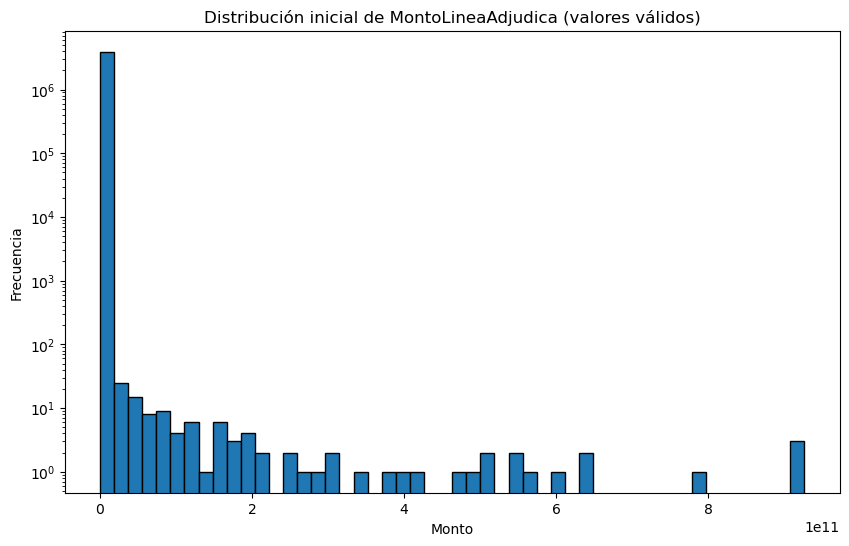

In [42]:
# Visualización inicial de la distribución
plt.figure(figsize=(10, 6))
plt.hist(valid_data['MontoLineaAdjudica'], bins=50, edgecolor='black')
plt.title('Distribución inicial de MontoLineaAdjudica (valores válidos)')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.yscale('log')  # Escala logarítmica para exponer valores más altos
plt.show()

In [43]:
valid_data.head()

,Codigo,Tipo de Adquisicion,NombreOrganismo,FechaPublicacion,CodigoProductoONU,NombreProveedor,Moneda de la Oferta,MontoUnitarioOferta,CantidadAdjudicada,MontoLineaAdjudica,Oferta seleccionada,Año,Sector,NombreProducto,RubroN2,NombreProveedorOriginal,NombreProveedorLimpio
0,7021685,Licitación Pública Mayor 1000 UTM (LP),SERVICIO NACIONAL DE TURISMO,2014-01-07,80111504,Brújula Consultoría Turística,Peso Chileno,380000000.0,1.0,380000000.0,Seleccionada,2014,NaN,"Formación, capacitación y entrenamiento de per...",Servicios de recursos humanos,Brújula Consultoría Turística,brujula consultoria turistica
10,7059568,Licitación Pública Mayor 1000 UTM (LP),JUNAEB,2014-01-08,76111501,MAGO-CHIC,Peso Chileno,156893511.0,1.0,156893504.0,Seleccionada,2014,NaN,Servicios de limpieza de edificios,Servicios de limpieza,MAGO-CHIC,magochic
11,7062082,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PUERTO MONTT SERVICIO DE SALUD DEL RE...,2014-01-23,51191601,Fresenius Kabi Chile Ltda.,Peso Chileno,4800.0,1200.0,5760000.0,Seleccionada,2014,Salud,Dextrosa,Agentes que afectan el agua y los electrolitos,Fresenius Kabi Chile Ltda.,fresenius kabi chile
13,7062082,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PUERTO MONTT SERVICIO DE SALUD DEL RE...,2014-01-23,51131903,Fresenius Kabi Chile Ltda.,Peso Chileno,3800.0,350.0,1330000.0,Seleccionada,2014,Salud,Gelatina,Medicamentos hematólicos,Fresenius Kabi Chile Ltda.,fresenius kabi chile
15,7062082,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PUERTO MONTT SERVICIO DE SALUD DEL RE...,2014-01-23,51142919,ABBVIE PRODUCTOS FARMACEUTICOS LIMITADA,Peso Chileno,8000.0,12.0,96000.0,Seleccionada,2014,Salud,Isoflurano,Medicamentos para el sistema nervioso central,ABBVIE PRODUCTOS FARMACEUTICOS LIMITADA,abbvie productos farmaceuticos


### 9.2 Caracteristicas Proveedor

In [44]:
import pandas as pd

# Supongamos que 'lic_all_years_clean' es tu DataFrame original
# Primero, creamos una copia del DataFrame para trabajar con ella
df = lic_all_years_clean_2014_2018.copy()

# Filtrar los montos adjudicados
df['MontoTotalAdjudicado'] = df['MontoLineaAdjudica'].where((df['MontoLineaAdjudica'] >= 1) & (df['MontoLineaAdjudica'] <= 10**12))

# Crear una columna que indique si la oferta fue seleccionada
df['Adjudicada'] = df['Oferta seleccionada'] == 'Seleccionada'

# Total adjudicaciones proveedor (solo las adjudicadas)
df['TotalAdjudicacionesProveedor'] = df.groupby('NombreProveedorLimpio')['Adjudicada'].transform('sum')

# Total participaciones proveedor
df['TotalParticipacionesProveedor'] = df.groupby('NombreProveedorLimpio')['Codigo'].transform('size')

# % Adjudicación proveedor
df['%AdjudicacionProveedor'] = (df['TotalAdjudicacionesProveedor'] / df['TotalParticipacionesProveedor']) * 100

# Total Monto adjudicado proveedor (filtrado)
df['TotalMontoAdjudicadoProveedor'] = df.groupby('NombreProveedorLimpio')['MontoTotalAdjudicado'].transform('sum')

# Total Monto promedio adjudicado proveedor (filtrado)
df['TotalMontoPromedioAdjudicadoProveedor'] = df.groupby('NombreProveedorLimpio')['MontoTotalAdjudicado'].transform('mean')

# Numero de rubros con ventaja
df['NumeroRubrosConVentaja'] = df.groupby('NombreProveedorLimpio')['RubroN2'].transform(lambda x: x.nunique())

# Total monto adjudicado rubro (filtrado)
df['TotalMontoAdjudicadoRubro'] = df.groupby('RubroN2')['MontoTotalAdjudicado'].transform('sum')

# Total monto promedio adjudicado rubro (filtrado)
df['TotalMontoPromedioAdjudicadoRubro'] = df.groupby('RubroN2')['MontoTotalAdjudicado'].transform('mean')

# Numero de proveedores rubro
df['NumeroProveedoresRubro'] = df.groupby('RubroN2')['NombreProveedorLimpio'].transform(lambda x: x.nunique())

In [45]:
# Mostrar el DataFrame resultante
df[["Codigo","Adjudicada","NombreProveedorLimpio","RubroN2","MontoTotalAdjudicado","TotalParticipacionesProveedor","TotalAdjudicacionesProveedor",
    "%AdjudicacionProveedor","TotalMontoAdjudicadoProveedor","TotalMontoPromedioAdjudicadoProveedor","NumeroRubrosConVentaja",
   "TotalMontoAdjudicadoRubro","TotalMontoPromedioAdjudicadoRubro","NumeroProveedoresRubro"]]

,Codigo,Adjudicada,NombreProveedorLimpio,RubroN2,MontoTotalAdjudicado,TotalParticipacionesProveedor,TotalAdjudicacionesProveedor,%AdjudicacionProveedor,TotalMontoAdjudicadoProveedor,TotalMontoPromedioAdjudicadoProveedor,NumeroRubrosConVentaja,TotalMontoAdjudicadoRubro,TotalMontoPromedioAdjudicadoRubro,NumeroProveedoresRubro
0,7021685,True,brujula consultoria turistica,Servicios de recursos humanos,380000000.0,62,7,11.290323,5.557500e+08,7.939286e+07,10,1.169177e+12,25926966.0,25660
1,7021685,False,lorena angelica,Servicios de recursos humanos,NaN,17,4,23.529412,7.213000e+07,1.803250e+07,5,1.169177e+12,25926966.0,25660
2,7021685,False,murillo y partners,Servicios de recursos humanos,NaN,49,16,32.653061,7.272000e+08,4.545000e+07,7,1.169177e+12,25926966.0,25660
3,7021685,False,universidad san sebastian,Servicios de recursos humanos,NaN,299,42,14.046823,1.252151e+09,2.981311e+07,13,1.169177e+12,25926966.0,25660
4,7021685,False,centro trapananda,Servicios de recursos humanos,NaN,30,5,16.666667,9.752500e+08,1.950500e+08,10,1.169177e+12,25926966.0,25660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23733906,8662096,False,winpharm,Medicamentos varios,NaN,260392,25099,9.638929,2.895406e+10,1.153594e+06,124,2.078517e+10,1577143.5,1138
23733907,8662096,False,ethon pharmaceuticals,Medicamentos hematólicos,NaN,350720,40523,11.554231,1.707017e+10,4.212778e+05,124,1.038724e+11,5511348.0,770
23733908,8662096,True,laboratorio chile,Medicamentos hematólicos,5691000.0,146376,43168,29.491173,4.644768e+10,1.075975e+06,71,1.038724e+11,5511348.0,770
23733909,8662096,False,winpharm,Medicamentos hematólicos,NaN,260392,25099,9.638929,2.895406e+10,1.153594e+06,124,1.038724e+11,5511348.0,770


In [46]:
density_df.shape

(38896270, 3)

In [47]:
# Eliminar duplicados en df para las claves de unión
df_proveedor = df[['NombreProveedorLimpio', 'TotalAdjudicacionesProveedor', 
                   'TotalParticipacionesProveedor', '%AdjudicacionProveedor', 
                   'TotalMontoAdjudicadoProveedor', 
                   'TotalMontoPromedioAdjudicadoProveedor', 
                   'NumeroRubrosConVentaja']].drop_duplicates()

df_rubro = df[['RubroN2', 'TotalMontoAdjudicadoRubro', 
                'TotalMontoPromedioAdjudicadoRubro', 
                'NumeroProveedoresRubro']].drop_duplicates()

# Realizar el merge para las características del proveedor
density_df = density_df.merge(df_proveedor, left_on='NombreProveedorLimpio', right_on='NombreProveedorLimpio', how='left')

# Realizar el merge para las características del rubro
density_df = density_df.merge(df_rubro, left_on='RubroPotencial', right_on='RubroN2', how='left')

# Eliminar las columnas que ya existen en density_df
columnas_a_eliminar = ['RubroN2']  # Agrega más columnas si es necesario
density_df = density_df.loc[:, ~density_df.columns.isin(columnas_a_eliminar)]

# Mostrar el DataFrame resultante
density_df.head()

,NombreProveedorLimpio,RubroPotencial,DensityRelatedness,TotalAdjudicacionesProveedor,TotalParticipacionesProveedor,%AdjudicacionProveedor,TotalMontoAdjudicadoProveedor,TotalMontoPromedioAdjudicadoProveedor,NumeroRubrosConVentaja,TotalMontoAdjudicadoRubro,TotalMontoPromedioAdjudicadoRubro,NumeroProveedoresRubro
0,01 moire,Consultorías o asesorías en gestión empresarial,0.079318,11,67,16.41791,12530001.0,1139091.0,13,1.435091e+11,28350268.0,5631
1,01 moire,Bibliotecas y otros centros de información púb...,0.046495,11,67,16.41791,12530001.0,1139091.0,13,3.854113e+10,25322688.0,826
2,01 moire,"Servicios de atención, mantenimiento y reparac...",0.059605,11,67,16.41791,12530001.0,1139091.0,13,8.933602e+11,17530272.0,17371
3,01 moire,Construcción de edificios en general,0.059004,11,67,16.41791,12530001.0,1139091.0,13,5.151139e+12,142876832.0,13008
4,01 moire,Servicios de recursos humanos,0.081196,11,67,16.41791,12530001.0,1139091.0,13,1.169177e+12,25926966.0,25660


### 9.3 Unir con metricas de Red

In [48]:
density_df.shape

(38896270, 12)

In [49]:
# Realizar el merge para las características del rubro
density_df = density_df.merge(metrics_df, left_on='RubroPotencial', right_on='Rubro', how='left')

# Eliminar las columnas que ya existen en density_df
columnas_a_eliminar_red = ['Rubro']  # Agrega más columnas si es necesario
density_df = density_df.loc[:, ~density_df.columns.isin(columnas_a_eliminar_red)]

In [23]:
density_df.head()

,NombreProveedorLimpio,RubroPotencial,DensityRelatedness,TotalAdjudicacionesProveedor,TotalParticipacionesProveedor,%AdjudicacionProveedor,TotalMontoAdjudicadoProveedor,TotalMontoPromedioAdjudicadoProveedor,NumeroRubrosConVentaja,TotalMontoAdjudicadoRubro,TotalMontoPromedioAdjudicadoRubro,NumeroProveedoresRubro,degree,weighted_degree,clustering_coefficient,Exito
0,01 moire,Consultorías o asesorías en gestión empresarial,0.079318,11,67,16.41791,12530001.0,1139091.0,13,1.435091e+11,28350268.0,5631,349,8.095106,0.014743,0
1,01 moire,Bibliotecas y otros centros de información púb...,0.046495,11,67,16.41791,12530001.0,1139091.0,13,3.854113e+10,25322688.0,826,324,6.730265,0.016121,0
2,01 moire,"Servicios de atención, mantenimiento y reparac...",0.059605,11,67,16.41791,12530001.0,1139091.0,13,8.933602e+11,17530272.0,17371,350,8.780972,0.015890,0
3,01 moire,Construcción de edificios en general,0.059004,11,67,16.41791,12530001.0,1139091.0,13,5.151139e+12,142876832.0,13008,348,8.476288,0.015523,0
4,01 moire,Servicios de recursos humanos,0.081196,11,67,16.41791,12530001.0,1139091.0,13,1.169177e+12,25926966.0,25660,347,6.159216,0.011096,0


## 10. Cargar y preprocesar datos de 2019 al 2023 [Generar Etiqueta]

In [51]:
lic_all_years_clean_2019_2023["Año"].unique()

array([2019, 2020, 2021, 2022, 2023], dtype=int64)

In [52]:
# Paso 1: Calcular el número total de participaciones en 2019-2023
participaciones_totales_2019_2023 = len(lic_all_years_clean_2019_2023)

# Paso 2: Calcular las participaciones únicas de cada proveedor en cada rubro
participaciones_proveedor_rubro_2019_2023 = lic_all_years_clean_2019_2023.groupby([proveedor_col, rubro_col]).size()

# Paso 3: Calcular las participaciones totales por proveedor
participaciones_totales_proveedor_2019_2023 = lic_all_years_clean_2019_2023[proveedor_col].value_counts()

# Paso 4: Calcular las participaciones totales por rubro
participaciones_totales_rubro_2019_2023 = lic_all_years_clean_2019_2023[rubro_col].value_counts()

# Combinar los cálculos en un DataFrame
vcr_df_2019_2023 = participaciones_proveedor_rubro_2019_2023.reset_index(name='participaciones_proveedor_rubro')
vcr_df_2019_2023['participaciones_totales_proveedor'] = vcr_df_2019_2023[proveedor_col].map(participaciones_totales_proveedor_2019_2023)
vcr_df_2019_2023['participaciones_totales_rubro'] = vcr_df_2019_2023[rubro_col].map(participaciones_totales_rubro_2019_2023)

# Calcular el VCR
vcr_df_2019_2023['VCR'] = (vcr_df_2019_2023['participaciones_proveedor_rubro'] / vcr_df_2019_2023['participaciones_totales_proveedor']) / \
                           (vcr_df_2019_2023['participaciones_totales_rubro'] / participaciones_totales_2019_2023)

# Determinar si tiene ventaja comparativa
vcr_df_2019_2023['ventaja_comparativa'] = vcr_df_2019_2023['VCR'] >= 1

In [53]:
vcr_df_2019_2023["ventaja_comparativa"].value_counts()

ventaja_comparativa
True     350979
False     78075
Name: count, dtype: int64

In [54]:
vcr_2019_2023_exito = vcr_df_2019_2023[vcr_df_2019_2023['ventaja_comparativa']][[proveedor_col, rubro_col]].copy()
vcr_2019_2023_exito['Exito'] = 1

In [55]:
vcr_2019_2023_exito.rename(columns={"RubroN2":"RubroPotencial"},inplace=True)

In [56]:
vcr_2019_2023_exito.columns

Index(['NombreProveedorLimpio', 'RubroPotencial', 'Exito'], dtype='object')

In [57]:
# Realizar el merge
density_df = density_df.merge(vcr_2019_2023_exito[['NombreProveedorLimpio', 'RubroPotencial','Exito']],
                              left_on=['NombreProveedorLimpio', 'RubroPotencial'],
                              right_on=['NombreProveedorLimpio', 'RubroPotencial'],
                              how='left')

In [58]:
density_df.columns

Index(['NombreProveedorLimpio', 'RubroPotencial', 'DensityRelatedness',
       'TotalAdjudicacionesProveedor', 'TotalParticipacionesProveedor',
       '%AdjudicacionProveedor', 'TotalMontoAdjudicadoProveedor',
       'TotalMontoPromedioAdjudicadoProveedor', 'NumeroRubrosConVentaja',
       'TotalMontoAdjudicadoRubro', 'TotalMontoPromedioAdjudicadoRubro',
       'NumeroProveedoresRubro', 'degree', 'weighted_degree',
       'clustering_coefficient', 'Exito'],
      dtype='object')

In [59]:
# Reemplazar NaN en 'Exito' por 0 (proveedores que no obtuvieron ventaja comparativa en el rubro potencial)
density_df['Exito'] = density_df['Exito'].fillna(0).astype(int)

In [60]:
# Verificar la distribución de la etiqueta
print(density_df['Exito'].value_counts())

Exito
0    38783857
1      112413
Name: count, dtype: int64


In [61]:
density_df.shape

(38896270, 16)

In [62]:
#pip install pyarrow

In [63]:
density_df.to_parquet("density_data.parquet", engine="pyarrow", compression="snappy")

In [23]:
# Para leer el archivo Parquet que guardaste anteriormente
density_df = pd.read_parquet("density_data.parquet")
density_df.shape

(38896270, 16)

In [24]:
density_df.columns

Index(['NombreProveedorLimpio', 'RubroPotencial', 'DensityRelatedness',
       'TotalAdjudicacionesProveedor', 'TotalParticipacionesProveedor',
       '%AdjudicacionProveedor', 'TotalMontoAdjudicadoProveedor',
       'TotalMontoPromedioAdjudicadoProveedor', 'NumeroRubrosConVentaja',
       'TotalMontoAdjudicadoRubro', 'TotalMontoPromedioAdjudicadoRubro',
       'NumeroProveedoresRubro', 'degree', 'weighted_degree',
       'clustering_coefficient', 'Exito'],
      dtype='object')

### Visualizaciones

C:\Users\chaco\AppData\Local\Temp\ipykernel_15092\1768998326.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = density_df.groupby('Density_Bin')['Exito'].mean()
C:\Users\chaco\AppData\Local\Temp\ipykernel_15092\1768998326.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_errors = density_df.groupby('Density_Bin')['Exito'].sem()  # Error estándar de la media


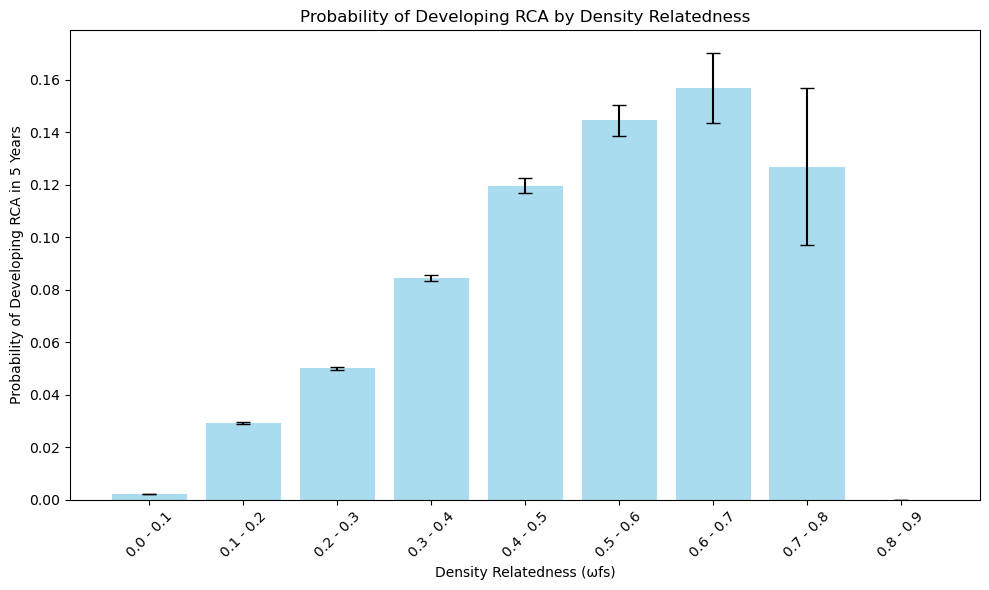

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Asegúrate de que la columna 'DensityRelatedness' y 'Exito' sean numéricas
density_df['DensityRelatedness'] = pd.to_numeric(density_df['DensityRelatedness'], errors='coerce')
density_df['Exito'] = pd.to_numeric(density_df['Exito'], errors='coerce')

# Dividir los valores de Density Relatedness en bins
bins = np.linspace(0, 1, 11)  # Dividir de 0 a 1 en 10 intervalos iguales
density_df['Density_Bin'] = pd.cut(density_df['DensityRelatedness'], bins=bins)

# Calcular la probabilidad promedio de éxito por bin y el error estándar
bin_means = density_df.groupby('Density_Bin')['Exito'].mean()
bin_errors = density_df.groupby('Density_Bin')['Exito'].sem()  # Error estándar de la media

# Etiquetas de los bins
bin_labels = [f'{round(b.left, 2)} - {round(b.right, 2)}' for b in bin_means.index]

# Graficar
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, bin_means, yerr=bin_errors, alpha=0.7, capsize=5, color='skyblue')
plt.xlabel('Density Relatedness (ωfs)')
plt.ylabel('Probability of Developing RCA in 5 Years')
plt.title('Probability of Developing RCA by Density Relatedness')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.tight_layout()  # Ajustar los márgenes
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Supongamos que 'proximidad_df' es tu matriz de proximidad y 'density_df' contiene los datos base.

# Eliminar la diagonal de la matriz de proximidad (sustituir por NaN)
np.fill_diagonal(proximidad_df.values, np.nan)

# Crear un diccionario con los rubros especializados (Mpr = 1) para cada proveedor
rubros_especializados = density_df[density_df['Exito'] == 1].groupby('NombreProveedorLimpio')['RubroPotencial'].apply(list)

# Inicializar una lista para almacenar la proximidad máxima
closest_proximity = []

# Iterar sobre cada fila de density_df
for index, row in density_df.iterrows():
    proveedor = row['NombreProveedorLimpio']
    rubro_potencial = row['RubroPotencial']
    
    # Obtener los rubros especializados del proveedor
    rubros_actuales = rubros_especializados.get(proveedor, [])
    
    if rubros_actuales:  # Si el proveedor tiene rubros especializados
        # Calcular la proximidad máxima al rubro potencial
        max_proximity = max(
            [proximidad_df.loc[rubro, rubro_potencial] 
             for rubro in rubros_actuales if rubro in proximidad_df.index and rubro != rubro_potencial], 
            default=np.nan
        )
    else:
        max_proximity = np.nan  # No hay proximidad si no tiene rubros actuales
    
    closest_proximity.append(max_proximity)

# Agregar la columna de proximidad más cercana a density_df
density_df['Closest_Proximity'] = closest_proximity

# Verificar resultados
print(density_df[['NombreProveedorLimpio', 'RubroPotencial', 'Closest_Proximity']].head())

C:\Users\chaco\AppData\Local\Temp\ipykernel_17704\787844762.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = density_df.groupby('Proximity_Bin')['Exito'].mean()
C:\Users\chaco\AppData\Local\Temp\ipykernel_17704\787844762.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_errors = density_df.groupby('Proximity_Bin')['Exito'].sem()


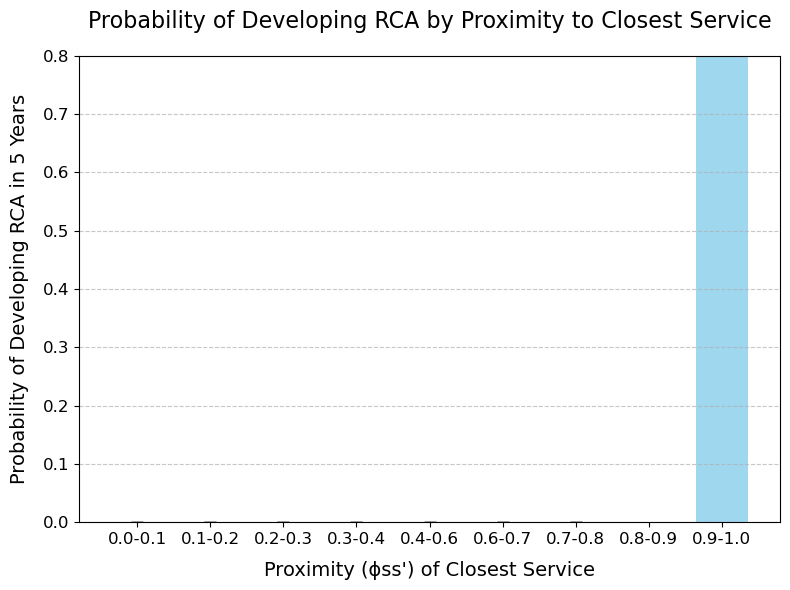

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los intervalos de proximidad
bins = np.arange(0, 1.1, 0.1)  # Intervalos de 0.1

# Crear una nueva columna para clasificar las proximidades en intervalos
density_df['Proximity_Bin'] = pd.cut(density_df['Closest_Proximity'], bins, right=False)

# Calcular la probabilidad de desarrollar RCA (éxito) por cada intervalo
probabilities = density_df.groupby('Proximity_Bin')['Exito'].mean()

# Calcular el tamaño de las muestras en cada intervalo
counts = density_df.groupby('Proximity_Bin')['Exito'].count()

# Calcular el error estándar
std_errors = (
    density_df.groupby('Proximity_Bin')['Exito'].std() / np.sqrt(counts)
)

# Graficar
plt.figure(figsize=(8, 6))
plt.bar(
    probabilities.index.astype(str), 
    probabilities, 
    yerr=std_errors, 
    alpha=0.7, 
    color='skyblue', 
    capsize=5
)
plt.xlabel("Proximity (ϕss') of Closest Service")
plt.ylabel("Probability of Developing RCA in 5 Years")
plt.title("Probability of Developing RCA by Proximity to Closest Service")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


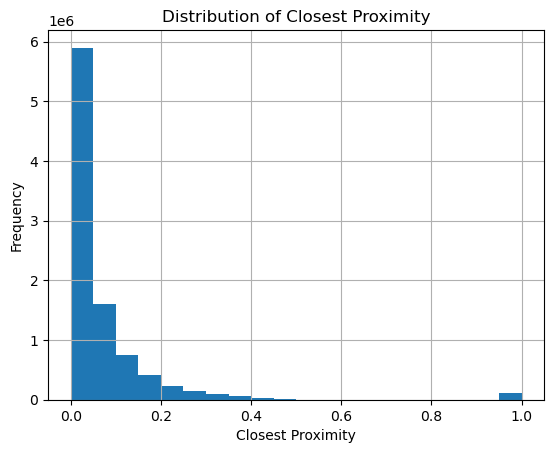

In [ ]:
density_df['Closest_Proximity'].describe()
density_df['Closest_Proximity'].hist(bins=20)
plt.xlabel('Closest Proximity')
plt.ylabel('Frequency')
plt.title('Distribution of Closest Proximity')
plt.show()


In [45]:
# Filtrar proveedores que hayan diversificado exitosamente en al menos 2 rubros
# Asegúrate de que el DataFrame 'density_df' tenga una columna llamada 'proveedor' y otra para 'rubro'

# Contar la cantidad de rubros distintos por proveedor
successful_diversification = density_df.groupby('NombreProveedorLimpio')['RubroPotencial'].nunique()

# Filtrar proveedores que tengan éxito en al menos 2 rubros
diversified_providers = successful_diversification[successful_diversification >= 2]

# Seleccionar un proveedor (el primero, por ejemplo)
if not diversified_providers.empty:
    proveedor_ejemplo = diversified_providers.index[0]
    print(f"Proveedor que diversificó exitosamente en al menos 2 rubros: {proveedor_ejemplo}")
else:
    print("No hay proveedores que hayan diversificado exitosamente en al menos 2 rubros.")


Proveedor que diversificó exitosamente en al menos 2 rubros: 01 moire


In [46]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo base desde la matriz de proximidad
G = nx.from_pandas_adjacency(proximidad_df)
G = nx.Graph(G)  # Asegurarse de que sea un grafo no dirigido

# Eliminar la diagonal (proximidad consigo mismo)
for node in G.nodes:
    if G.has_edge(node, node):
        G.remove_edge(node, node)


In [48]:
density_df.columns

Index(['NombreProveedorLimpio', 'RubroPotencial', 'DensityRelatedness',
       'TotalAdjudicacionesProveedor', 'TotalParticipacionesProveedor',
       '%AdjudicacionProveedor', 'TotalMontoAdjudicadoProveedor',
       'TotalMontoPromedioAdjudicadoProveedor', 'NumeroRubrosConVentaja',
       'TotalMontoAdjudicadoRubro', 'TotalMontoPromedioAdjudicadoRubro',
       'NumeroProveedoresRubro', 'degree', 'weighted_degree',
       'clustering_coefficient', 'Exito', 'MontoAdjudicadoNormalizado',
       'NormalizedMontoAdjudicado'],
      dtype='object')

In [61]:
# Filtrar proveedores con Exito = 1
proveedores_exito = density_df[density_df['Exito'] == 1]

# Contar la cantidad de rubros exitosos por proveedor
proveedores_conteo = proveedores_exito.groupby('NombreProveedorLimpio')['RubroPotencial'].count()

# Filtrar proveedores con al menos 2 rubros exitosos
proveedores_al_menos_dos = proveedores_conteo[proveedores_conteo >= 2].index.tolist()

# Mostrar los resultados
print("Proveedores con al menos 2 rubros exitosos:", proveedores_al_menos_dos)


Proveedores con al menos 2 rubros exitosos: ['0bdo santiago casa matriz', '0range grafica', '1 activa publicidad', '1 arica xpression publicitaria', '1 reifschneider casa matriz', '100356023', '101082725', '101170209', '102360796', '103053900', '103363705', '10348958k', '10353108k', '104919227', '108199415', '108358122', '109472042', '111844186', '11195996k', '114330469', '116898330', '11802753', '119974143', '123 somnus', '123029801', '123148053', '123904877', '126549563', '12833341k', '12856134', '13 grau rm', '130004792', '130016464', '130028616', '133511008', '135158992', '135991457', '137655489', '137843889', '139522494', '13969760k', '143252124', '14487854k', '151810632', '15363413', '154373446', '155165006', '157577271', '159865150', '165847369', '166771560', '17569207k', '18159747k', '1a imprenta', '1promocional eirl', '1publimor', '2 emeingenieria', '2 janssencilag chile', '2602ing', '2cabeza', '2m regalos e impresiones corporativas', '3 vientos', '311', '32 consultoria ras it

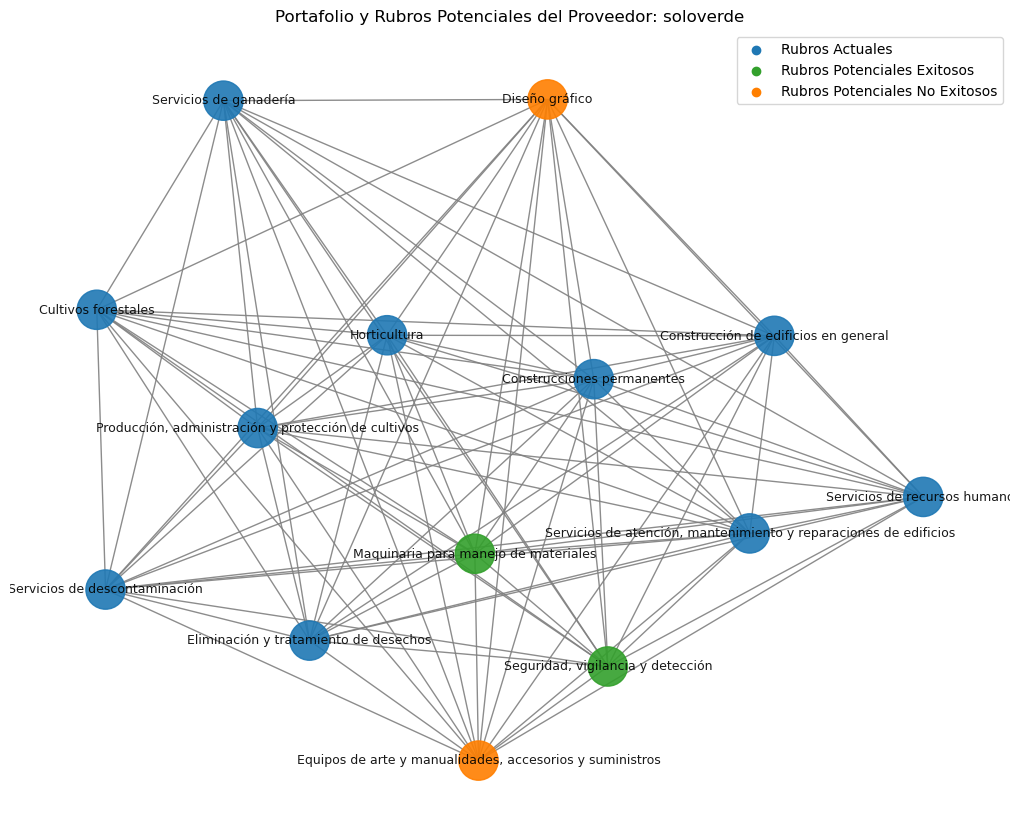

In [66]:
    import networkx as nx
    import matplotlib.pyplot as plt

    # Filtrar portafolio actual (rubros con VCR > 1)
    proveedor = "soloverde"
    portafolio_actual = vcr_df[(vcr_df['NombreProveedorLimpio'] == proveedor) & (vcr_df['VCR'] > 1)]

    # Identificar rubros potenciales desde density_df
    rubros_potenciales = density_df[density_df['NombreProveedorLimpio'] == proveedor]

    # Seleccionar 2 rubros exitosos y 2 no exitosos
    rubros_exitosos = rubros_potenciales[rubros_potenciales['Exito'] == True].head(2)
    rubros_no_exitosos = rubros_potenciales[rubros_potenciales['Exito'] == False].head(2)

    # Combinar todos los nodos (actuales y potenciales)
    nodos_actuales = portafolio_actual['RubroN2'].tolist()
    nodos_exitosos = rubros_exitosos['RubroPotencial'].tolist()
    nodos_no_exitosos = rubros_no_exitosos['RubroPotencial'].tolist()
    todos_nodos = nodos_actuales + nodos_exitosos + nodos_no_exitosos

    # Crear el grafo desde proximidad_df filtrando nodos relevantes
    G = nx.Graph()
    for nodo in todos_nodos:
        G.add_node(nodo, tipo='actual' if nodo in nodos_actuales else 'exitoso' if nodo in nodos_exitosos else 'no_exitoso')

    for i, nodo1 in enumerate(todos_nodos):
        for nodo2 in todos_nodos[i + 1:]:
            if nodo1 in proximidad_df.index and nodo2 in proximidad_df.columns:
                peso = proximidad_df.loc[nodo1, nodo2]
                if peso > 0:  # Filtrar solo conexiones relevantes
                    G.add_edge(nodo1, nodo2, weight=peso)

    # Asignar colores mejorados a los nodos
    color_map_actuales = '#1f78b4'  # Azul intenso
    color_map_exitosos = '#33a02c'  # Verde esmeralda
    color_map_no_exitosos = '#ff7f00'  # Naranja brillante
    node_colors = [
        color_map_actuales if G.nodes[n]['tipo'] == 'actual' 
        else color_map_exitosos if G.nodes[n]['tipo'] == 'exitoso' 
        else color_map_no_exitosos 
        for n in G.nodes
    ]

    # Dibujar el grafo
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Ajustar posiciones
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_size=9, alpha=0.9)

    # Agregar leyenda
    legend_labels = {
        color_map_actuales: 'Rubros Actuales',
        color_map_exitosos: 'Rubros Potenciales Exitosos',
        color_map_no_exitosos: 'Rubros Potenciales No Exitosos'
    }
    for color, label in legend_labels.items():
        plt.scatter([], [], color=color, label=label)
    plt.legend(loc='best')

    plt.title(f'Portafolio y Rubros Potenciales del Proveedor: {proveedor}')
    plt.show()

In [65]:
# Exportar el grafo en formato GraphML
file_path = "grafo_portafolio.graphml"
nx.write_graphml(G, file_path)

## 11. Definir las Características (Variables Predictoras) y la Etiqueta

In [ ]:
def reduce_memory_usage(df):
    """Reduce el uso de memoria de un DataFrame."""
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:  # Excluir columnas categóricas
            if str(col_type).startswith('int'):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif str(col_type).startswith('float'):
                df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# Reducir el uso de memoria
density_df = reduce_memory_usage(density_df)

# Verificar la reducción de memoria
print(density_df.info())


MemoryError: Unable to allocate 297. MiB for an array with shape (38896270,) and data type float64

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Variables predictoras (excluyendo 'RubroPotencial' y 'NombreProveedor')
X = density_df.drop(['RubroPotencial', "NombreProveedorLimpio", "Exito"], axis=1)

# Crear un escalador
scaler = StandardScaler()

# Ajustar y transformar X
X = scaler.fit_transform(X)

# Convertir X_scaled de nuevo a un DataFrame y asignar los nombres de las columnas
X = pd.DataFrame(X, columns=X.columns)

# Etiqueta (variable objetivo)
y = density_df['Exito']

MemoryError: Unable to allocate 3.77 GiB for an array with shape (38896270, 13) and data type float64

In [ ]:
X.columns

Index(['DensityRelatedness', 'TotalAdjudicacionesProveedor',
       'TotalParticipacionesProveedor', '%AdjudicacionProveedor',
       'TotalMontoAdjudicadoProveedor',
       'TotalMontoPromedioAdjudicadoProveedor', 'NumeroRubrosConVentaja',
       'TotalMontoAdjudicadoRubro', 'TotalMontoPromedioAdjudicadoRubro',
       'NumeroProveedoresRubro', 'degree', 'weighted_degree',
       'clustering_coefficient'],
      dtype='object')

In [ ]:
# Reemplazar valores NaN por 0 o por la media/mediana según corresponda
X = X.fillna(0)

# También puedes optar por eliminar filas con valores faltantes
# X = X.dropna()
# y = y[X.index]


## 12. Implementar Modelo 

In [ ]:
#pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

# Dividir los datos originales en entrenamiento y prueba (proporción original)
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

c:\Users\chaco\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\chaco\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\chaco\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\chaco\anaconda3\Lib\site-packages\


### Results for Proportion 1 ###
Accuracy: 0.83

Classification Report:
              precision    recall  f1-score       support
0              0.999475  0.832266  0.908239  7.756771e+06
1              0.014463  0.849219  0.028441  2.248300e+04
accuracy       0.832315  0.832315  0.832315  8.323154e-01
macro avg      0.506969  0.840743  0.468340  7.779254e+06
weighted avg   0.996628  0.832315  0.905696  7.779254e+06

Confusion Matrix:
[[6455700 1301071]
 [   3390   19093]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    717.0   13.680595
4           TotalMontoAdjudicadoProveedor    585.0   11.161992
5   TotalMontoPromedioAdjudicadoProveedor    567.0   10.818546
3                  %AdjudicacionProveedor    491.0    9.368441
2           TotalParticipacionesProveedor    455.0    8.681549
6                  NumeroRubrosConVentaja    455.0    8.681549
9                  NumeroProveedoresRubro    410.0    7.822

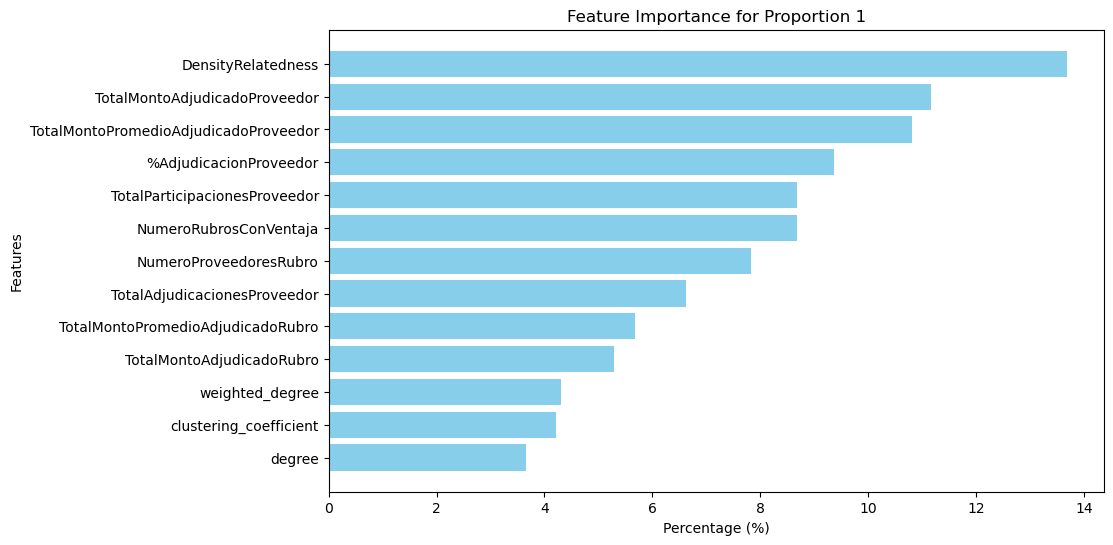

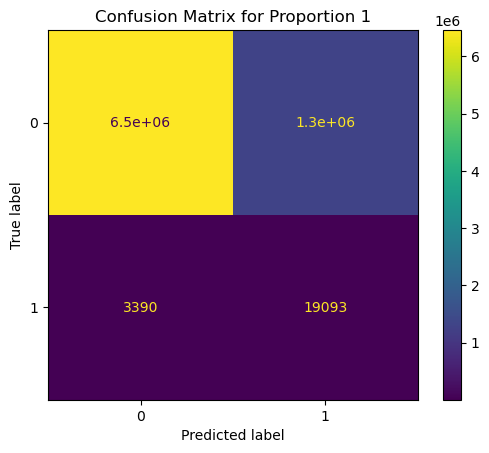


### Results for Proportion 2 ###
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score       support
0              0.999209  0.901200  0.947677  7.756771e+06
1              0.021635  0.753770  0.042063  2.248300e+04
accuracy       0.900774  0.900774  0.900774  9.007739e-01
macro avg      0.510422  0.827485  0.494870  7.779254e+06
weighted avg   0.996383  0.900774  0.945060  7.779254e+06

Confusion Matrix:
[[6990402  766369]
 [   5536   16947]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    681.0   12.557625
4           TotalMontoAdjudicadoProveedor    588.0   10.842707
5   TotalMontoPromedioAdjudicadoProveedor    560.0   10.326388
2           TotalParticipacionesProveedor    540.0    9.957588
3                  %AdjudicacionProveedor    533.0    9.828508
6                  NumeroRubrosConVentaja    532.0    9.810068
9                  NumeroProveedoresRubro    425.0    7.836

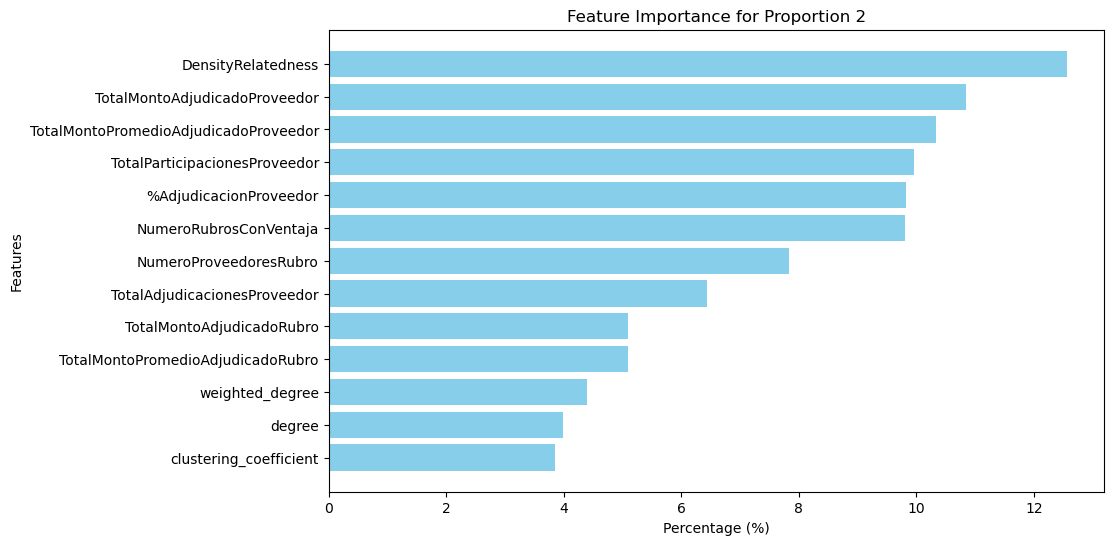

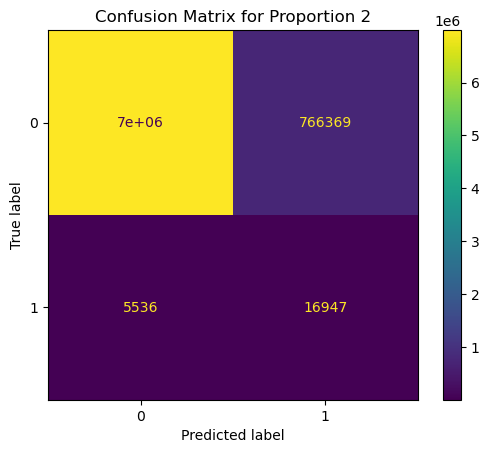


### Results for Proportion 3 ###
Accuracy: 0.93

Classification Report:
              precision    recall  f1-score       support
0              0.999008  0.930700  0.963645  7.756771e+06
1              0.027698  0.681092  0.053231  2.248300e+04
accuracy       0.929979  0.929979  0.929979  9.299786e-01
macro avg      0.513353  0.805896  0.508438  7.779254e+06
weighted avg   0.996201  0.929979  0.961014  7.779254e+06

Confusion Matrix:
[[7219227  537544]
 [   7170   15313]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    713.0   12.777778
4           TotalMontoAdjudicadoProveedor    662.0   11.863799
3                  %AdjudicacionProveedor    554.0    9.928315
5   TotalMontoPromedioAdjudicadoProveedor    547.0    9.802867
2           TotalParticipacionesProveedor    538.0    9.641577
6                  NumeroRubrosConVentaja    538.0    9.641577
9                  NumeroProveedoresRubro    427.0    7.652

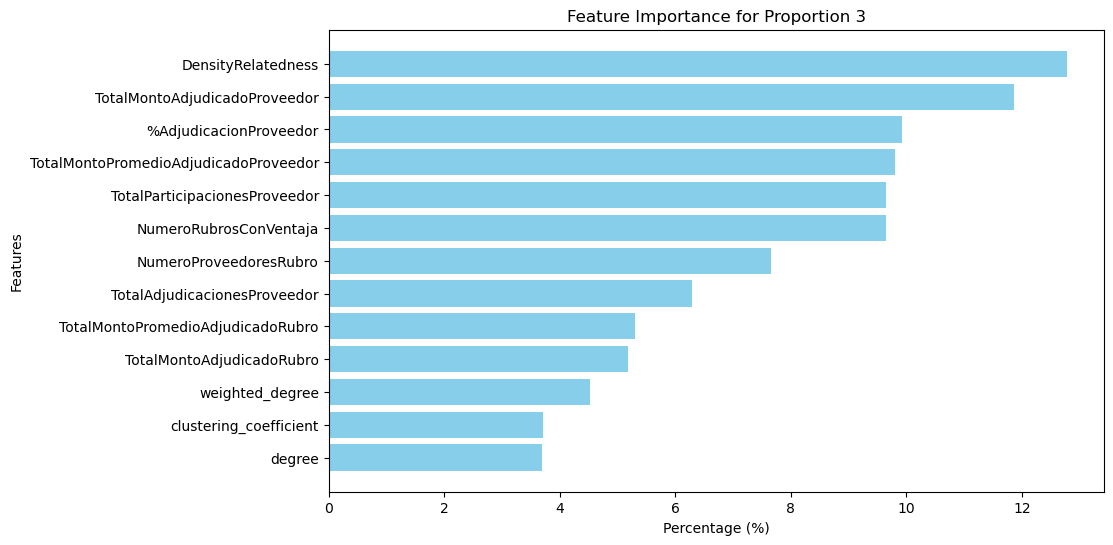

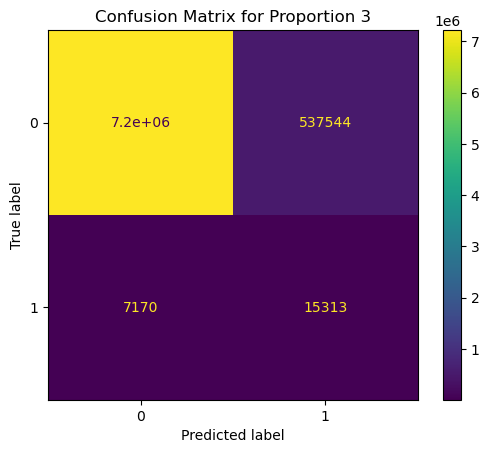


### Results for Proportion 5 ###
Accuracy: 0.96

Classification Report:
              precision    recall  f1-score       support
0              0.998719  0.958090  0.977983  7.756771e+06
1              0.038321  0.576169  0.071862  2.248300e+04
accuracy       0.956986  0.956986  0.956986  9.569864e-01
macro avg      0.518520  0.767129  0.524923  7.779254e+06
weighted avg   0.995944  0.956986  0.975364  7.779254e+06

Confusion Matrix:
[[7431686  325085]
 [   9529   12954]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    697.0   12.450875
5   TotalMontoPromedioAdjudicadoProveedor    617.0   11.021793
4           TotalMontoAdjudicadoProveedor    604.0   10.789568
6                  NumeroRubrosConVentaja    599.0   10.700250
3                  %AdjudicacionProveedor    566.0   10.110754
2           TotalParticipacionesProveedor    543.0    9.699893
9                  NumeroProveedoresRubro    393.0    7.020

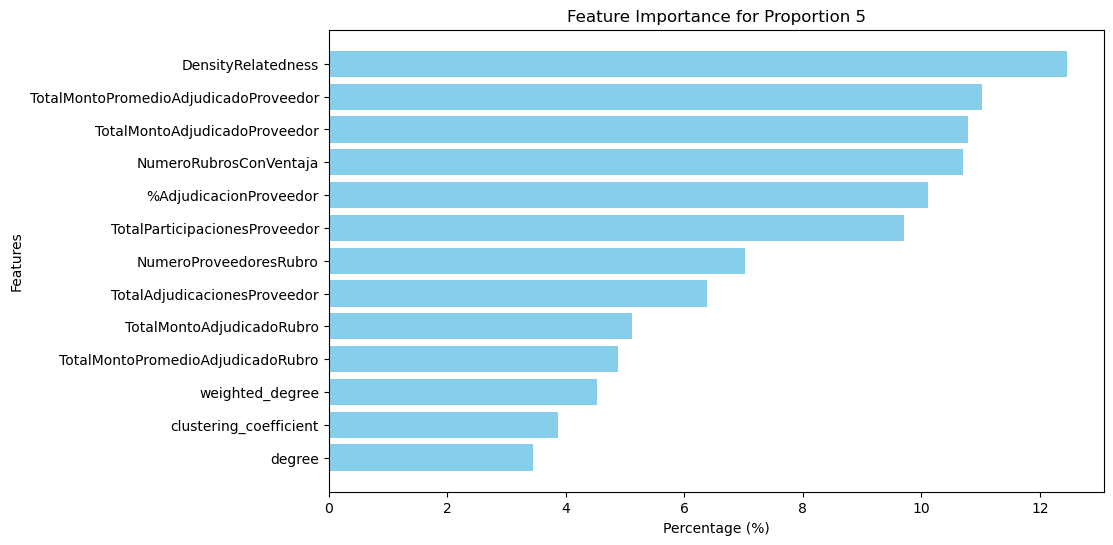

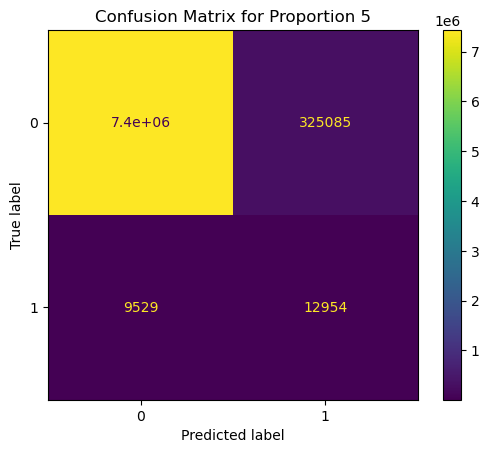


### Results for Proportion 7 ###
Accuracy: 0.97

Classification Report:
              precision    recall  f1-score       support
0              0.998497  0.971287  0.984704  7.756771e+06
1              0.047648  0.495619  0.086938  2.248300e+04
accuracy       0.969913  0.969913  0.969913  9.699125e-01
macro avg      0.523073  0.733453  0.535821  7.779254e+06
weighted avg   0.995749  0.969913  0.982110  7.779254e+06

Confusion Matrix:
[[7534053  222718]
 [  11340   11143]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    734.0   13.011877
4           TotalMontoAdjudicadoProveedor    626.0   11.097323
5   TotalMontoPromedioAdjudicadoProveedor    605.0   10.725049
6                  NumeroRubrosConVentaja    601.0   10.654139
3                  %AdjudicacionProveedor    548.0    9.714590
2           TotalParticipacionesProveedor    544.0    9.643680
9                  NumeroProveedoresRubro    426.0    7.551

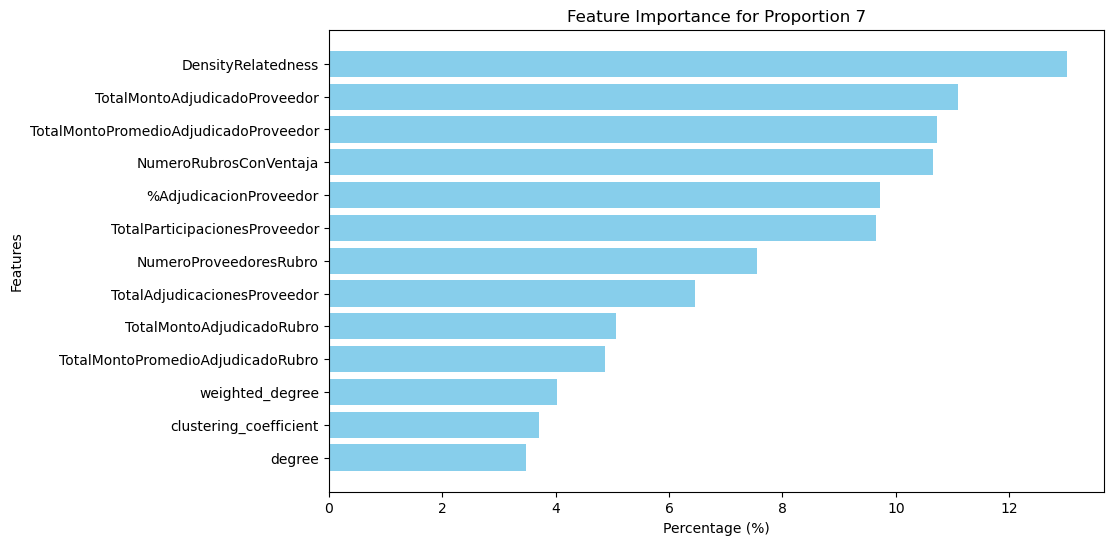

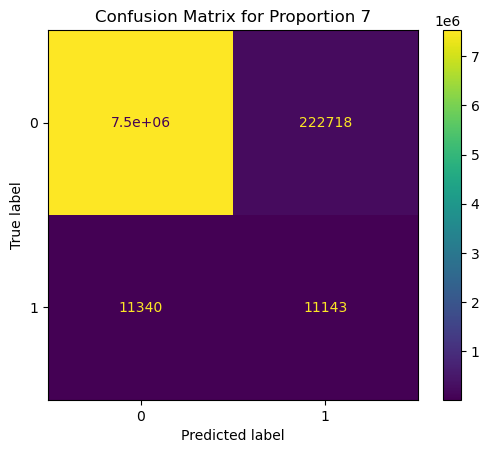


### Results for Proportion 10 ###
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score       support
0              0.998265  0.982088  0.990110  7.756771e+06
1              0.062387  0.411200  0.108338  2.248300e+04
accuracy       0.980438  0.980438  0.980438  9.804377e-01
macro avg      0.530326  0.696644  0.549224  7.779254e+06
weighted avg   0.995560  0.980438  0.987562  7.779254e+06

Confusion Matrix:
[[7617829  138942]
 [  13238    9245]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    665.0   11.813821
4           TotalMontoAdjudicadoProveedor    651.0   11.565109
5   TotalMontoPromedioAdjudicadoProveedor    636.0   11.298632
6                  NumeroRubrosConVentaja    617.0   10.961094
3                  %AdjudicacionProveedor    575.0   10.214958
2           TotalParticipacionesProveedor    529.0    9.397762
9                  NumeroProveedoresRubro    408.0    7.24

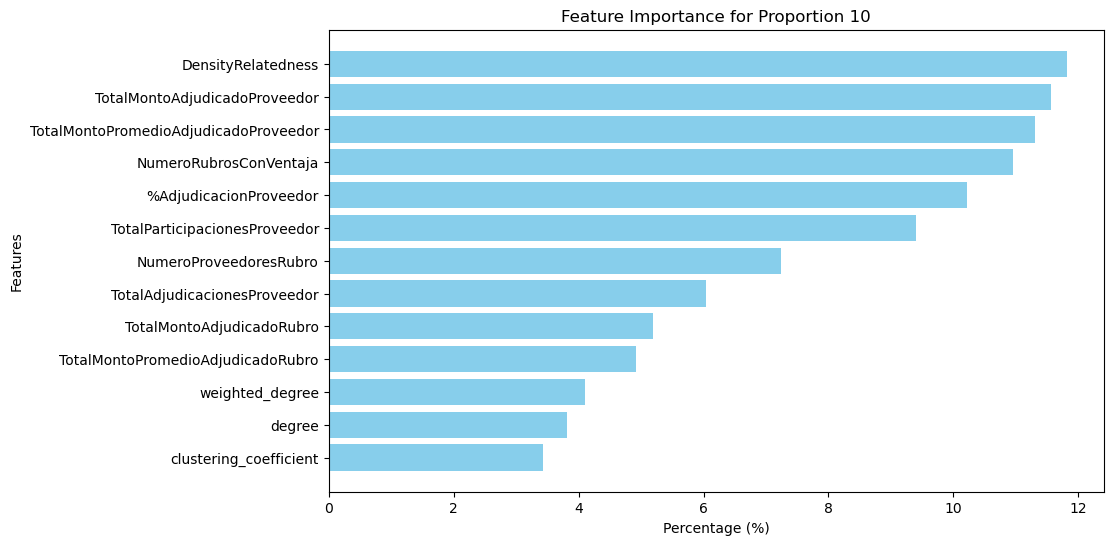

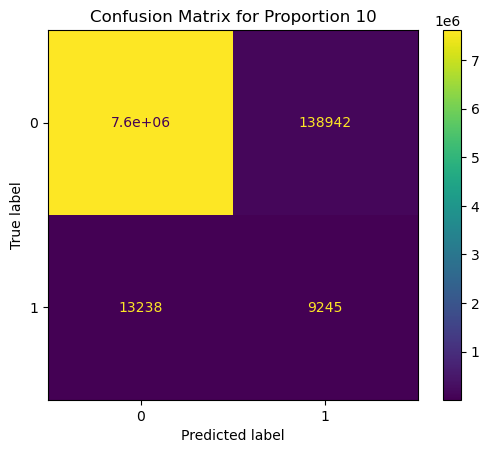


### Results for Proportion 15 ###
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score       support
0              0.998001  0.990085  0.994027  7.756771e+06
1              0.084537  0.315883  0.133378  2.248300e+04
accuracy       0.988136  0.988136  0.988136  9.881364e-01
macro avg      0.541269  0.652984  0.563703  7.779254e+06
weighted avg   0.995361  0.988136  0.991540  7.779254e+06

Confusion Matrix:
[[7679862   76909]
 [  15381    7102]]

Feature Importance:
                                  Feature  F_Score  Percentage
4           TotalMontoAdjudicadoProveedor    683.0   12.014072
0                      DensityRelatedness    665.0   11.697449
5   TotalMontoPromedioAdjudicadoProveedor    657.0   11.556728
3                  %AdjudicacionProveedor    585.0   10.290237
6                  NumeroRubrosConVentaja    579.0   10.184697
2           TotalParticipacionesProveedor    535.0    9.410730
9                  NumeroProveedoresRubro    447.0    7.86

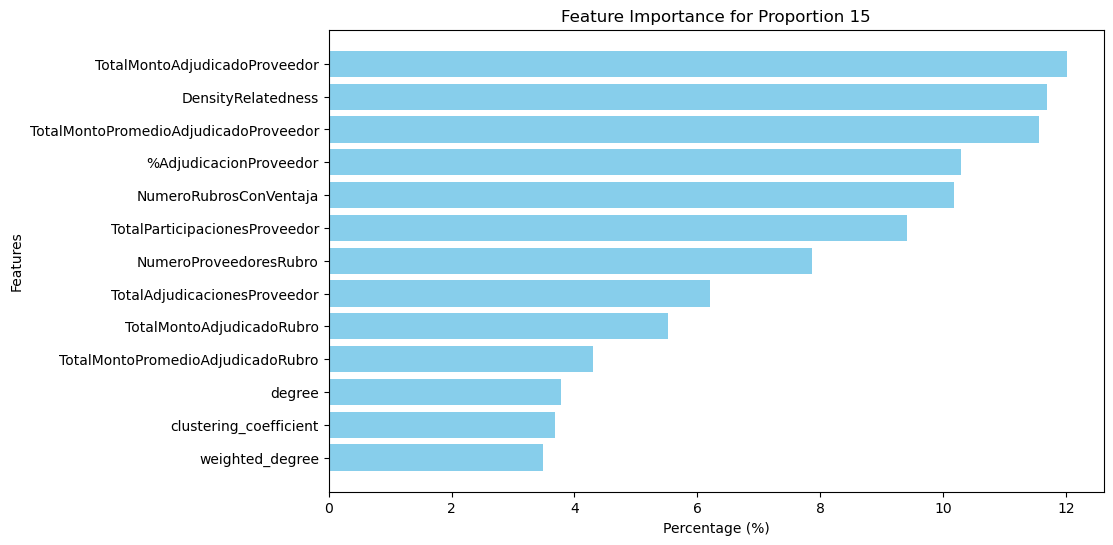

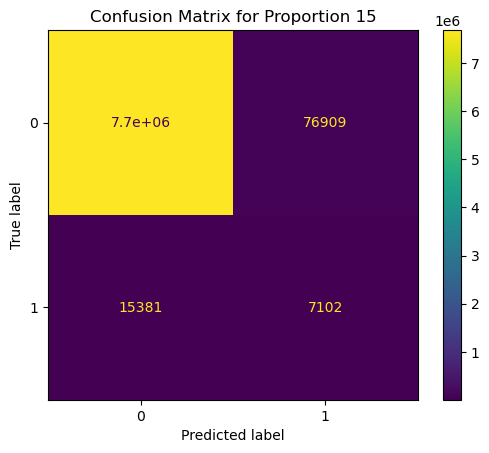


### Results for Proportion 20 ###
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score       support
0              0.997809  0.993894  0.995848  7.756771e+06
1              0.105002  0.247165  0.147389  2.248300e+04
accuracy       0.991735  0.991735  0.991735  9.917355e-01
macro avg      0.551405  0.620529  0.571618  7.779254e+06
weighted avg   0.995229  0.991735  0.993395  7.779254e+06

Confusion Matrix:
[[7709405   47366]
 [  16926    5557]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    677.0   11.893886
6                  NumeroRubrosConVentaja    659.0   11.577653
5   TotalMontoPromedioAdjudicadoProveedor    657.0   11.542516
4           TotalMontoAdjudicadoProveedor    635.0   11.156008
3                  %AdjudicacionProveedor    571.0   10.031623
2           TotalParticipacionesProveedor    519.0    9.118060
9                  NumeroProveedoresRubro    427.0    7.50

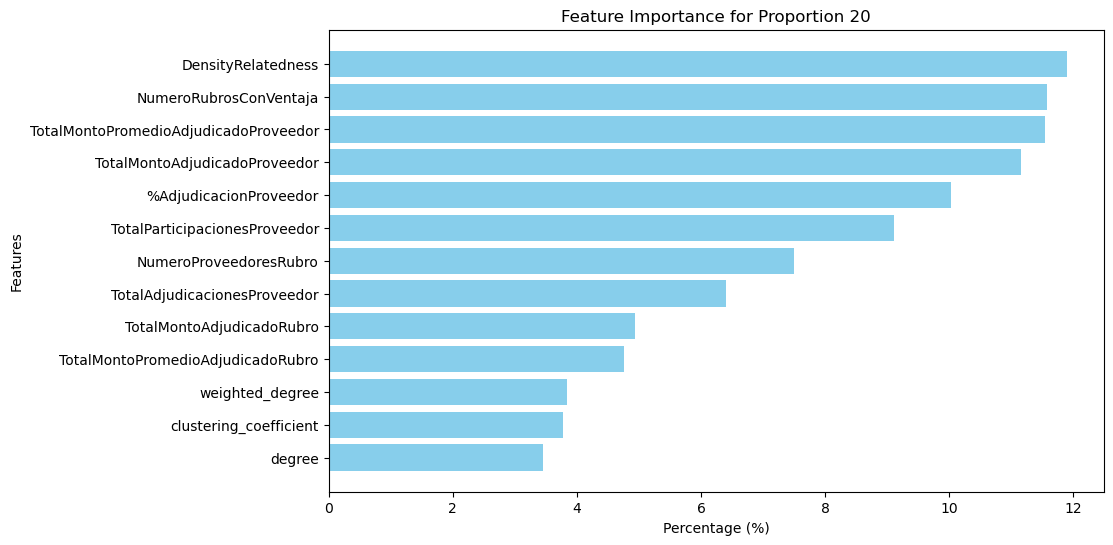

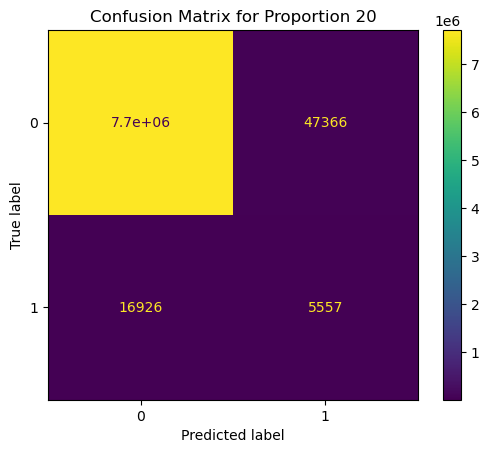


### Results for Proportion 25 ###
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score       support
0              0.997674  0.995847  0.996760  7.756771e+06
1              0.121882  0.198861  0.151134  2.248300e+04
accuracy       0.993544  0.993544  0.993544  9.935439e-01
macro avg      0.559778  0.597354  0.573947  7.779254e+06
weighted avg   0.995142  0.993544  0.994316  7.779254e+06

Confusion Matrix:
[[7724559   32212]
 [  18012    4471]]

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    660.0   11.544516
6                  NumeroRubrosConVentaja    650.0   11.369599
4           TotalMontoAdjudicadoProveedor    626.0   10.949799
5   TotalMontoPromedioAdjudicadoProveedor    611.0   10.687423
3                  %AdjudicacionProveedor    548.0    9.585447
2           TotalParticipacionesProveedor    539.0    9.428022
9                  NumeroProveedoresRubro    452.0    7.90

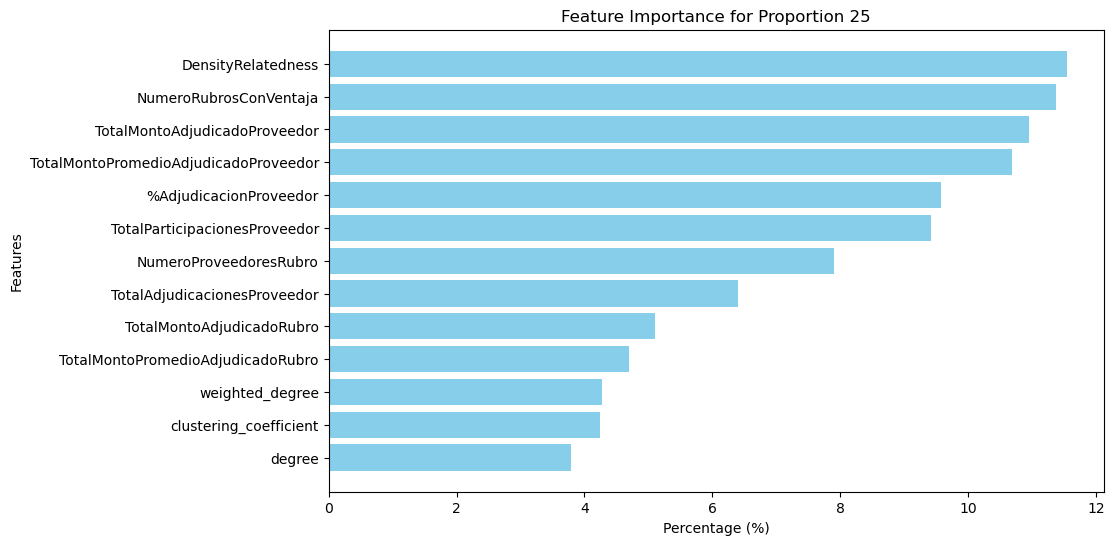

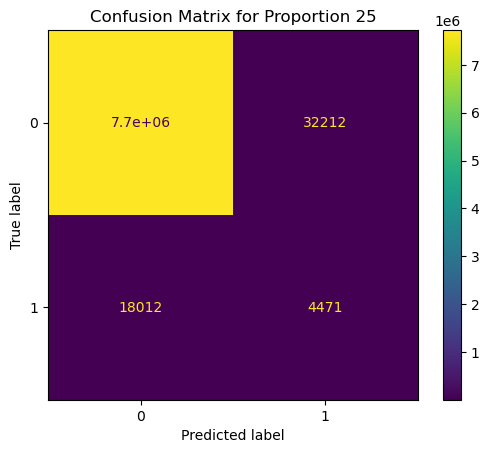

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# Definir los datos originales (asegúrate de que `X_train_original` y `y_train_original` estén definidos)
data_train = X_train_original.copy()
data_train['Exito'] = y_train_original

# Separar las clases
data_majority = data_train[data_train['Exito'] == 0]
data_minority = data_train[data_train['Exito'] == 1]

# Definir las proporciones a evaluar
proportions = [1, 2, 3, 5, 7, 10, 15, 20, 25]
results = []


# Evaluar cada proporción
for proportion in proportions:
    # Submuestrear la clase mayoritaria
    data_majority_downsampled = resample(
        data_majority,
        replace=False,  # Sin reemplazo
        n_samples=len(data_minority) * proportion,
        random_state=42
    )
    
    # Combinar la clase minoritaria con la clase mayoritaria submuestreada
    data_balanced = pd.concat([data_majority_downsampled, data_minority])
    
    # Separar X y y en el conjunto balanceado
    X_train = data_balanced.drop('Exito', axis=1)
    y_train = data_balanced['Exito']
    
    # Crear y entrenar el modelo
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calcular AUC-ROC y AUC-PR
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    
    # Guardar la importancia de las variables
    importance = model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'F_Score': list(importance.values())
    })
    importance_df['Percentage'] = (importance_df['F_Score'] / importance_df['F_Score'].sum()) * 100
    importance_df = importance_df.sort_values(by='Percentage', ascending=False)
    
    # Guardar los resultados
    results.append({
        'Proportion': proportion,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Feature Importance': importance_df
    })

# Crear un DataFrame con las métricas generales
metrics_df = pd.DataFrame([{
    'Proportion': r['Proportion'],
    'Accuracy': r['Accuracy'],
    'Precision': r['Precision'],
    'Recall': r['Recall'],
    'F1-Score': r['F1-Score'],
    'AUC-ROC': r['AUC-ROC'],
    'AUC-PR': r['AUC-PR']
} for r in results])

# Mostrar métricas generales al usuario
print("\n### Final Comparison Table ###")
print(metrics_df)



############################################################
### Results for Proportion 1 ###
############################################################

Summary Metrics:
  - Accuracy: 0.83
  - Precision: 0.01
  - Recall: 0.85
  - F1-Score: 0.03

Classification Report:
              precision    recall  f1-score       support
0              0.999475  0.832266  0.908239  7.756771e+06
1              0.014463  0.849219  0.028441  2.248300e+04
accuracy       0.832315  0.832315  0.832315  8.323154e-01
macro avg      0.506969  0.840743  0.468340  7.779254e+06
weighted avg   0.996628  0.832315  0.905696  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      6455700      1301071
Actual 1         3390        19093




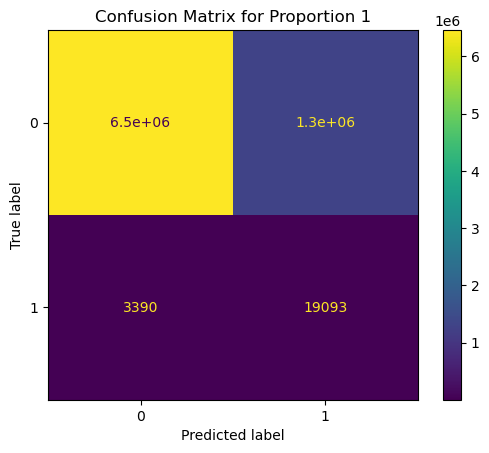

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    717.0   13.680595
4           TotalMontoAdjudicadoProveedor    585.0   11.161992
5   TotalMontoPromedioAdjudicadoProveedor    567.0   10.818546
3                  %AdjudicacionProveedor    491.0    9.368441
2           TotalParticipacionesProveedor    455.0    8.681549
6                  NumeroRubrosConVentaja    455.0    8.681549
9                  NumeroProveedoresRubro    410.0    7.822935
1            TotalAdjudicacionesProveedor    347.0    6.620874
8       TotalMontoPromedioAdjudicadoRubro    298.0    5.685938
7               TotalMontoAdjudicadoRubro    277.0    5.285251
11                        weighted_degree    226.0    4.312154
12                 clustering_coefficient    221.0    4.216753
10                                 degree    192.0    3.663423




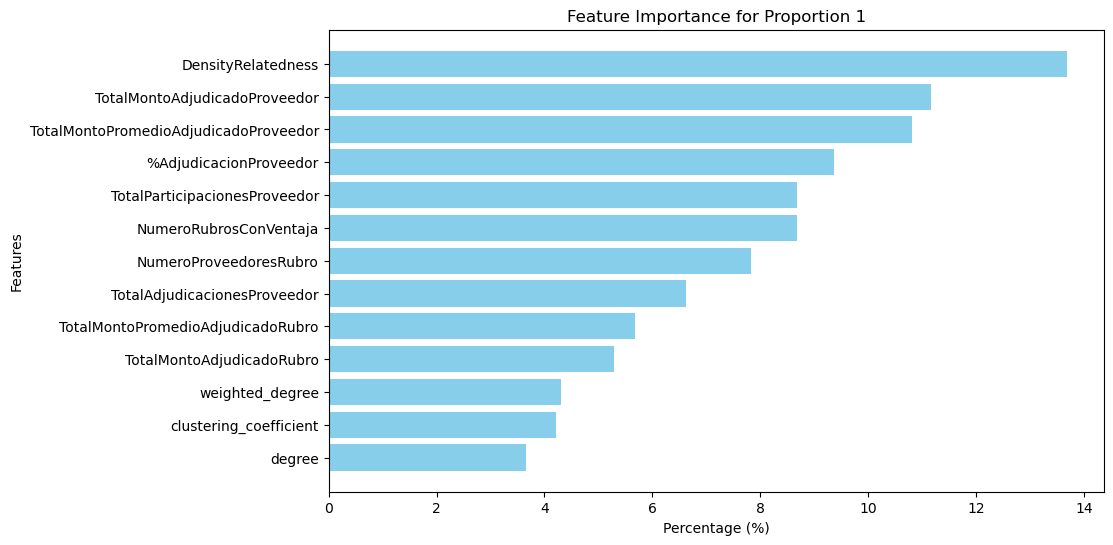


############################################################
### Results for Proportion 2 ###
############################################################

Summary Metrics:
  - Accuracy: 0.90
  - Precision: 0.02
  - Recall: 0.75
  - F1-Score: 0.04

Classification Report:
              precision    recall  f1-score       support
0              0.999209  0.901200  0.947677  7.756771e+06
1              0.021635  0.753770  0.042063  2.248300e+04
accuracy       0.900774  0.900774  0.900774  9.007739e-01
macro avg      0.510422  0.827485  0.494870  7.779254e+06
weighted avg   0.996383  0.900774  0.945060  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      6990402       766369
Actual 1         5536        16947




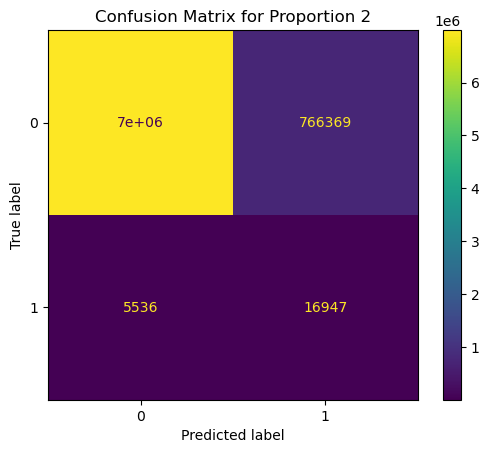

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    681.0   12.557625
4           TotalMontoAdjudicadoProveedor    588.0   10.842707
5   TotalMontoPromedioAdjudicadoProveedor    560.0   10.326388
2           TotalParticipacionesProveedor    540.0    9.957588
3                  %AdjudicacionProveedor    533.0    9.828508
6                  NumeroRubrosConVentaja    532.0    9.810068
9                  NumeroProveedoresRubro    425.0    7.836991
1            TotalAdjudicacionesProveedor    349.0    6.435552
7               TotalMontoAdjudicadoRubro    276.0    5.089434
8       TotalMontoPromedioAdjudicadoRubro    276.0    5.089434
11                        weighted_degree    238.0    4.388715
10                                 degree    216.0    3.983035
12                 clustering_coefficient    209.0    3.853955




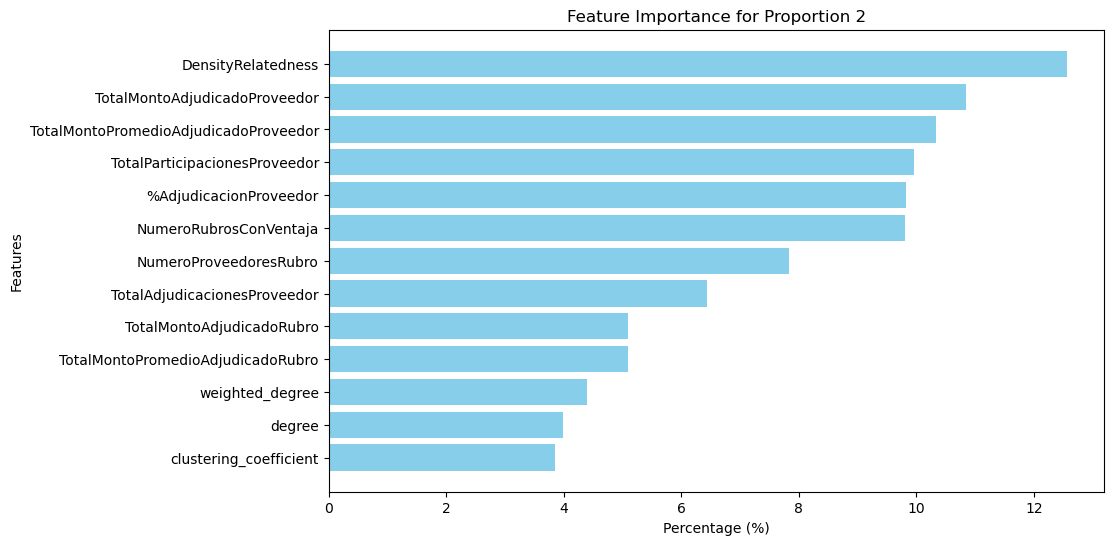


############################################################
### Results for Proportion 3 ###
############################################################

Summary Metrics:
  - Accuracy: 0.93
  - Precision: 0.03
  - Recall: 0.68
  - F1-Score: 0.05

Classification Report:
              precision    recall  f1-score       support
0              0.999008  0.930700  0.963645  7.756771e+06
1              0.027698  0.681092  0.053231  2.248300e+04
accuracy       0.929979  0.929979  0.929979  9.299786e-01
macro avg      0.513353  0.805896  0.508438  7.779254e+06
weighted avg   0.996201  0.929979  0.961014  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7219227       537544
Actual 1         7170        15313




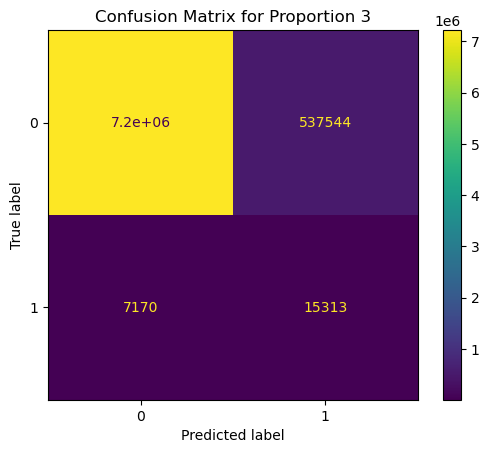

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    713.0   12.777778
4           TotalMontoAdjudicadoProveedor    662.0   11.863799
3                  %AdjudicacionProveedor    554.0    9.928315
5   TotalMontoPromedioAdjudicadoProveedor    547.0    9.802867
2           TotalParticipacionesProveedor    538.0    9.641577
6                  NumeroRubrosConVentaja    538.0    9.641577
9                  NumeroProveedoresRubro    427.0    7.652330
1            TotalAdjudicacionesProveedor    351.0    6.290323
8       TotalMontoPromedioAdjudicadoRubro    296.0    5.304659
7               TotalMontoAdjudicadoRubro    289.0    5.179211
11                        weighted_degree    252.0    4.516129
12                 clustering_coefficient    207.0    3.709677
10                                 degree    206.0    3.691756




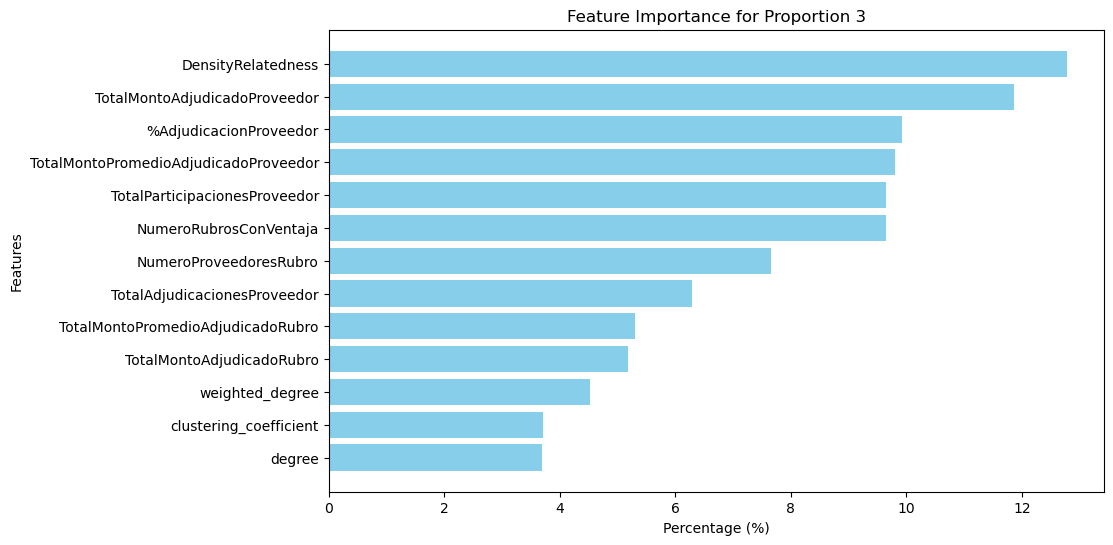


############################################################
### Results for Proportion 5 ###
############################################################

Summary Metrics:
  - Accuracy: 0.96
  - Precision: 0.04
  - Recall: 0.58
  - F1-Score: 0.07

Classification Report:
              precision    recall  f1-score       support
0              0.998719  0.958090  0.977983  7.756771e+06
1              0.038321  0.576169  0.071862  2.248300e+04
accuracy       0.956986  0.956986  0.956986  9.569864e-01
macro avg      0.518520  0.767129  0.524923  7.779254e+06
weighted avg   0.995944  0.956986  0.975364  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7431686       325085
Actual 1         9529        12954




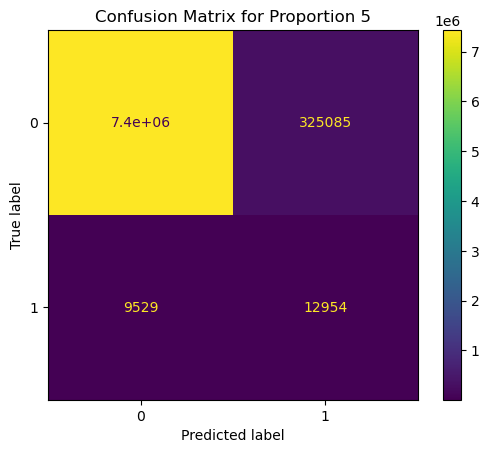

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    697.0   12.450875
5   TotalMontoPromedioAdjudicadoProveedor    617.0   11.021793
4           TotalMontoAdjudicadoProveedor    604.0   10.789568
6                  NumeroRubrosConVentaja    599.0   10.700250
3                  %AdjudicacionProveedor    566.0   10.110754
2           TotalParticipacionesProveedor    543.0    9.699893
9                  NumeroProveedoresRubro    393.0    7.020364
1            TotalAdjudicacionesProveedor    357.0    6.377278
7               TotalMontoAdjudicadoRubro    286.0    5.108967
8       TotalMontoPromedioAdjudicadoRubro    273.0    4.876742
11                        weighted_degree    253.0    4.519471
12                 clustering_coefficient    217.0    3.876384
10                                 degree    193.0    3.447660




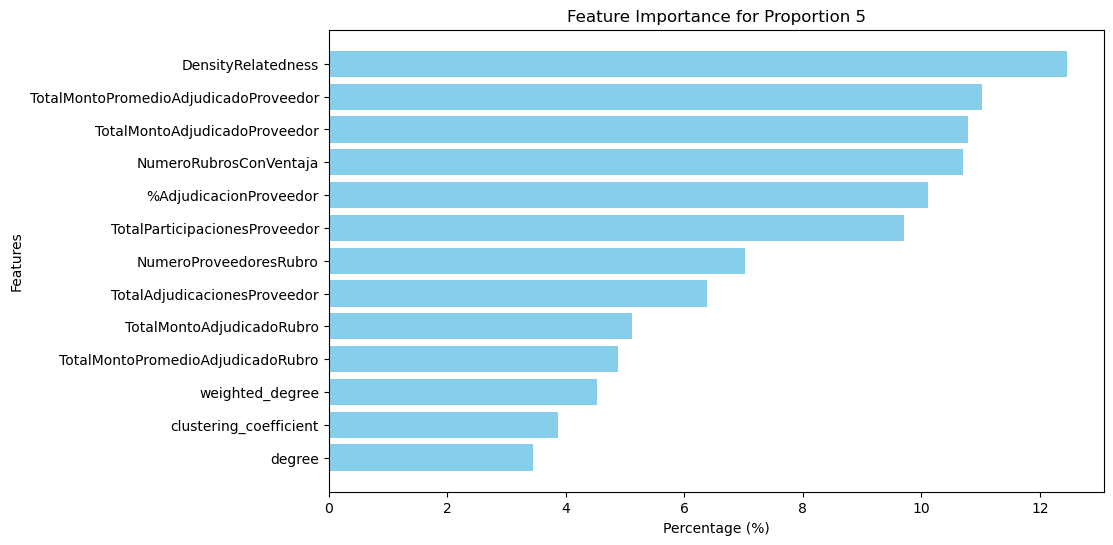


############################################################
### Results for Proportion 7 ###
############################################################

Summary Metrics:
  - Accuracy: 0.97
  - Precision: 0.05
  - Recall: 0.50
  - F1-Score: 0.09

Classification Report:
              precision    recall  f1-score       support
0              0.998497  0.971287  0.984704  7.756771e+06
1              0.047648  0.495619  0.086938  2.248300e+04
accuracy       0.969913  0.969913  0.969913  9.699125e-01
macro avg      0.523073  0.733453  0.535821  7.779254e+06
weighted avg   0.995749  0.969913  0.982110  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7534053       222718
Actual 1        11340        11143




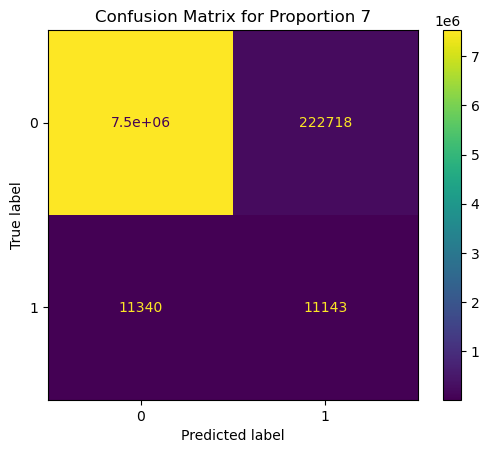

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    734.0   13.011877
4           TotalMontoAdjudicadoProveedor    626.0   11.097323
5   TotalMontoPromedioAdjudicadoProveedor    605.0   10.725049
6                  NumeroRubrosConVentaja    601.0   10.654139
3                  %AdjudicacionProveedor    548.0    9.714590
2           TotalParticipacionesProveedor    544.0    9.643680
9                  NumeroProveedoresRubro    426.0    7.551853
1            TotalAdjudicacionesProveedor    364.0    6.452757
7               TotalMontoAdjudicadoRubro    286.0    5.070023
8       TotalMontoPromedioAdjudicadoRubro    275.0    4.875022
11                        weighted_degree    227.0    4.024109
12                 clustering_coefficient    209.0    3.705017
10                                 degree    196.0    3.474561




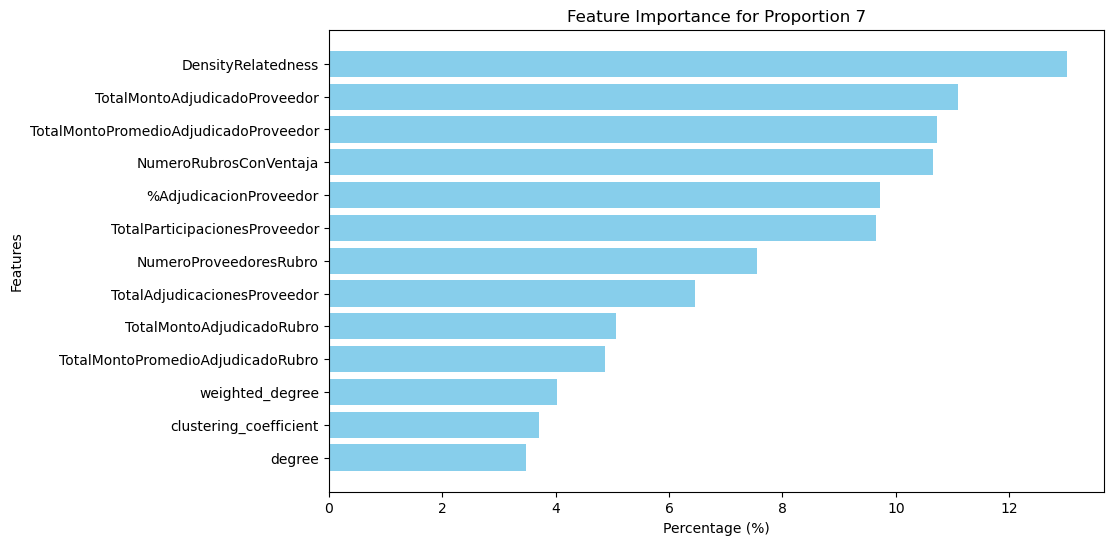


############################################################
### Results for Proportion 10 ###
############################################################

Summary Metrics:
  - Accuracy: 0.98
  - Precision: 0.06
  - Recall: 0.41
  - F1-Score: 0.11

Classification Report:
              precision    recall  f1-score       support
0              0.998265  0.982088  0.990110  7.756771e+06
1              0.062387  0.411200  0.108338  2.248300e+04
accuracy       0.980438  0.980438  0.980438  9.804377e-01
macro avg      0.530326  0.696644  0.549224  7.779254e+06
weighted avg   0.995560  0.980438  0.987562  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7617829       138942
Actual 1        13238         9245




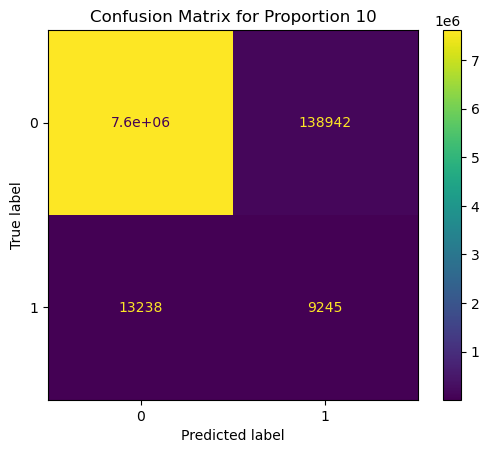

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    665.0   11.813821
4           TotalMontoAdjudicadoProveedor    651.0   11.565109
5   TotalMontoPromedioAdjudicadoProveedor    636.0   11.298632
6                  NumeroRubrosConVentaja    617.0   10.961094
3                  %AdjudicacionProveedor    575.0   10.214958
2           TotalParticipacionesProveedor    529.0    9.397762
9                  NumeroProveedoresRubro    408.0    7.248179
1            TotalAdjudicacionesProveedor    340.0    6.040149
7               TotalMontoAdjudicadoRubro    292.0    5.187422
8       TotalMontoPromedioAdjudicadoRubro    277.0    4.920945
11                        weighted_degree    231.0    4.103748
10                                 degree    215.0    3.819506
12                 clustering_coefficient    193.0    3.428673




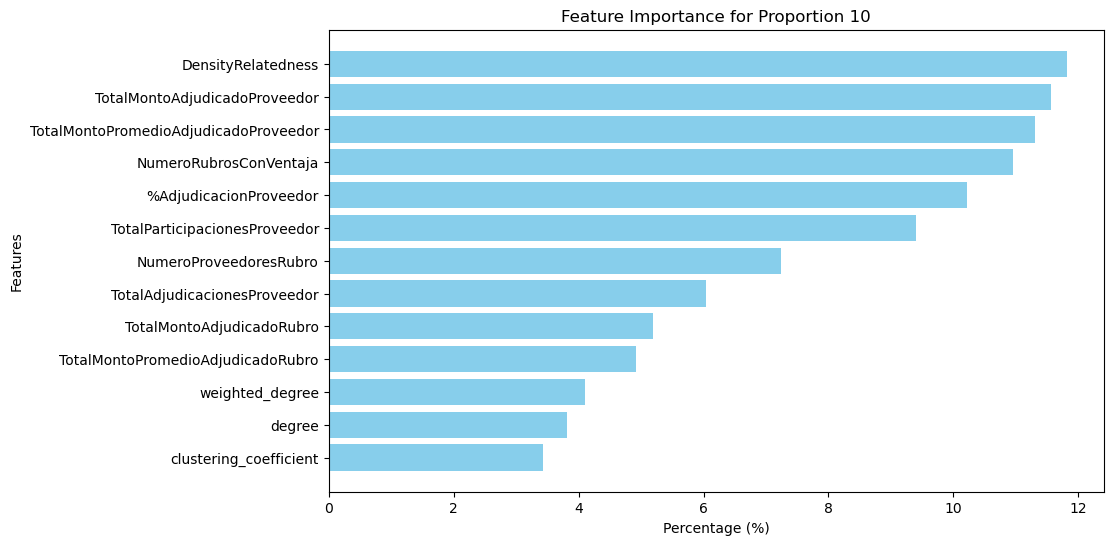


############################################################
### Results for Proportion 15 ###
############################################################

Summary Metrics:
  - Accuracy: 0.99
  - Precision: 0.08
  - Recall: 0.32
  - F1-Score: 0.13

Classification Report:
              precision    recall  f1-score       support
0              0.998001  0.990085  0.994027  7.756771e+06
1              0.084537  0.315883  0.133378  2.248300e+04
accuracy       0.988136  0.988136  0.988136  9.881364e-01
macro avg      0.541269  0.652984  0.563703  7.779254e+06
weighted avg   0.995361  0.988136  0.991540  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7679862        76909
Actual 1        15381         7102




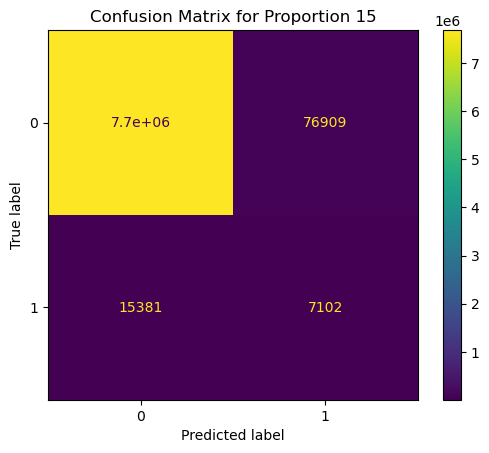

Feature Importance:
                                  Feature  F_Score  Percentage
4           TotalMontoAdjudicadoProveedor    683.0   12.014072
0                      DensityRelatedness    665.0   11.697449
5   TotalMontoPromedioAdjudicadoProveedor    657.0   11.556728
3                  %AdjudicacionProveedor    585.0   10.290237
6                  NumeroRubrosConVentaja    579.0   10.184697
2           TotalParticipacionesProveedor    535.0    9.410730
9                  NumeroProveedoresRubro    447.0    7.862797
1            TotalAdjudicacionesProveedor    353.0    6.209323
7               TotalMontoAdjudicadoRubro    314.0    5.523307
8       TotalMontoPromedioAdjudicadoRubro    245.0    4.309587
10                                 degree    215.0    3.781882
12                 clustering_coefficient    209.0    3.676341
11                        weighted_degree    198.0    3.482850




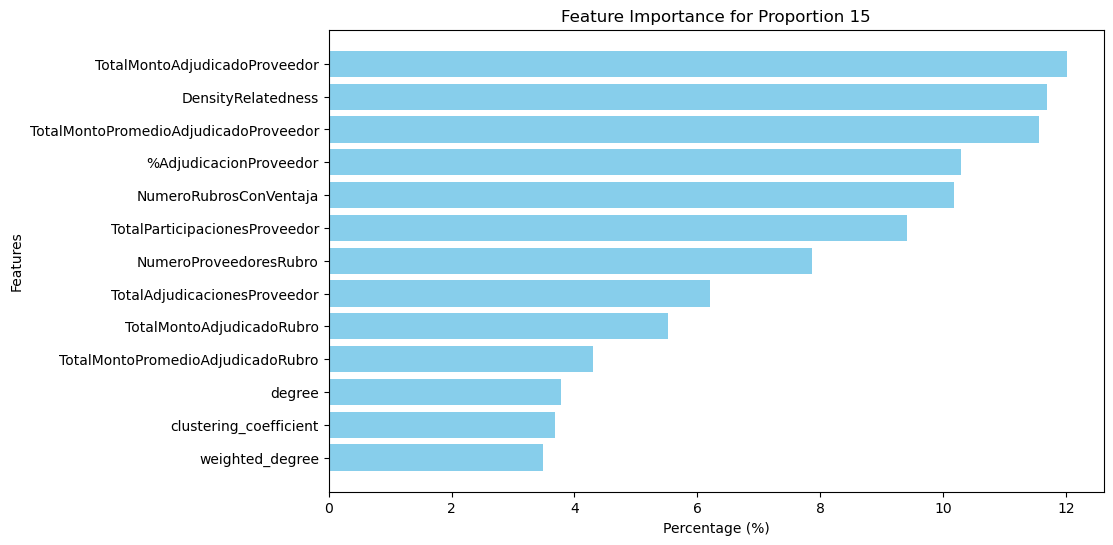


############################################################
### Results for Proportion 20 ###
############################################################

Summary Metrics:
  - Accuracy: 0.99
  - Precision: 0.11
  - Recall: 0.25
  - F1-Score: 0.15

Classification Report:
              precision    recall  f1-score       support
0              0.997809  0.993894  0.995848  7.756771e+06
1              0.105002  0.247165  0.147389  2.248300e+04
accuracy       0.991735  0.991735  0.991735  9.917355e-01
macro avg      0.551405  0.620529  0.571618  7.779254e+06
weighted avg   0.995229  0.991735  0.993395  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7709405        47366
Actual 1        16926         5557




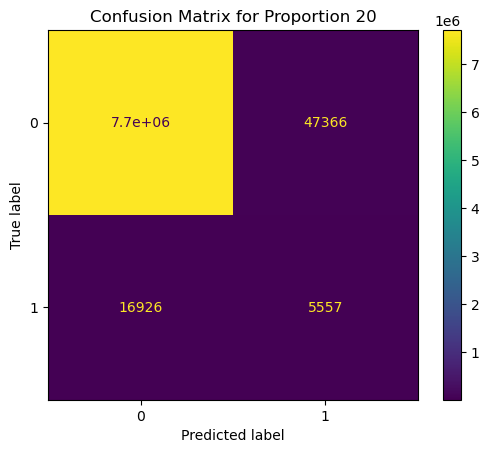

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    677.0   11.893886
6                  NumeroRubrosConVentaja    659.0   11.577653
5   TotalMontoPromedioAdjudicadoProveedor    657.0   11.542516
4           TotalMontoAdjudicadoProveedor    635.0   11.156008
3                  %AdjudicacionProveedor    571.0   10.031623
2           TotalParticipacionesProveedor    519.0    9.118060
9                  NumeroProveedoresRubro    427.0    7.501757
1            TotalAdjudicacionesProveedor    364.0    6.394940
7               TotalMontoAdjudicadoRubro    281.0    4.936753
8       TotalMontoPromedioAdjudicadoRubro    271.0    4.761068
11                        weighted_degree    219.0    3.847505
12                 clustering_coefficient    215.0    3.777231
10                                 degree    197.0    3.460998




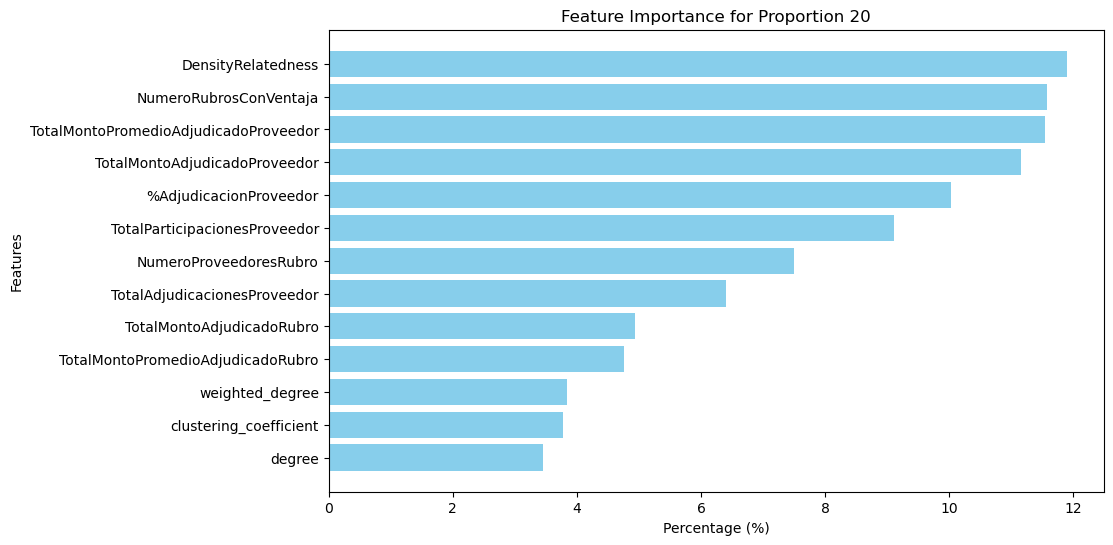


############################################################
### Results for Proportion 25 ###
############################################################

Summary Metrics:
  - Accuracy: 0.99
  - Precision: 0.12
  - Recall: 0.20
  - F1-Score: 0.15

Classification Report:
              precision    recall  f1-score       support
0              0.997674  0.995847  0.996760  7.756771e+06
1              0.121882  0.198861  0.151134  2.248300e+04
accuracy       0.993544  0.993544  0.993544  9.935439e-01
macro avg      0.559778  0.597354  0.573947  7.779254e+06
weighted avg   0.995142  0.993544  0.994316  7.779254e+06


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0      7724559        32212
Actual 1        18012         4471




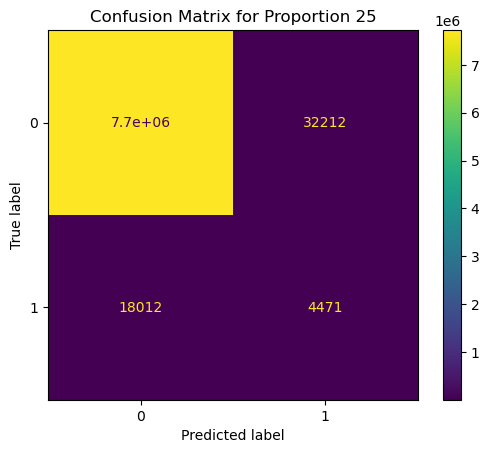

Feature Importance:
                                  Feature  F_Score  Percentage
0                      DensityRelatedness    660.0   11.544516
6                  NumeroRubrosConVentaja    650.0   11.369599
4           TotalMontoAdjudicadoProveedor    626.0   10.949799
5   TotalMontoPromedioAdjudicadoProveedor    611.0   10.687423
3                  %AdjudicacionProveedor    548.0    9.585447
2           TotalParticipacionesProveedor    539.0    9.428022
9                  NumeroProveedoresRubro    452.0    7.906245
1            TotalAdjudicacionesProveedor    366.0    6.401959
7               TotalMontoAdjudicadoRubro    292.0    5.107574
8       TotalMontoPromedioAdjudicadoRubro    269.0    4.705265
11                        weighted_degree    244.0    4.267973
12                 clustering_coefficient    243.0    4.250481
10                                 degree    217.0    3.795697




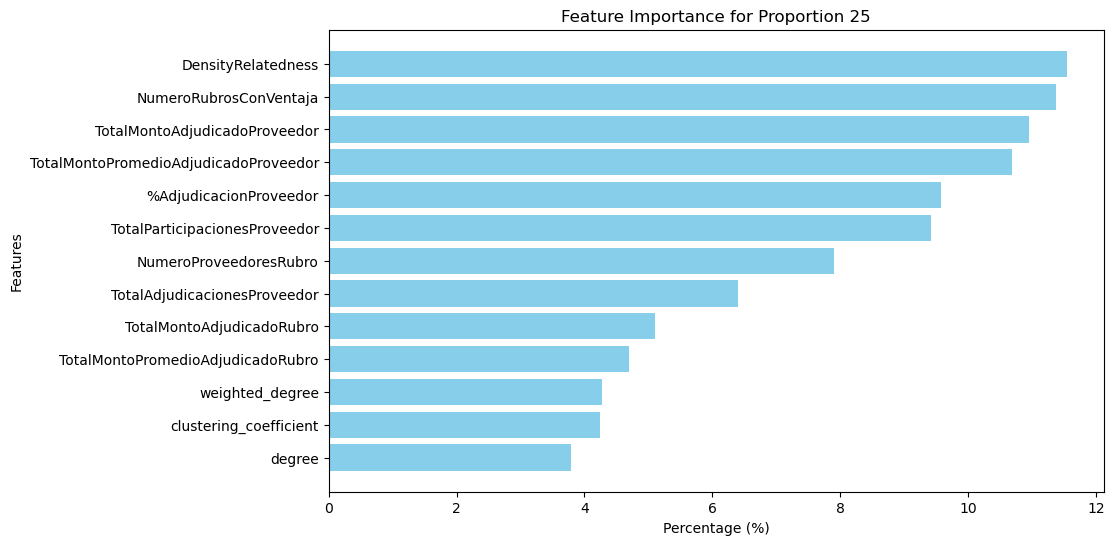

In [ ]:
# Mostrar detalles con un formato más ordenado
for result in results:
    proportion = result['Proportion']
    
    print(f"\n{'#' * 60}")
    print(f"### Results for Proportion {proportion} ###")
    print(f"{'#' * 60}\n")
    
    # Resumen de métricas principales
    print("Summary Metrics:")
    print(f"  - Accuracy: {result['Accuracy']:.2f}")
    print(f"  - Precision: {result['Precision']:.2f}")
    print(f"  - Recall: {result['Recall']:.2f}")
    print(f"  - F1-Score: {result['F1-Score']:.2f}\n")
    
    # Reporte de clasificación
    print("Classification Report:")
    report_df = pd.DataFrame(result['Classification Report']).transpose()
    print(report_df)
    print("\n")
    
    # Matriz de confusión (tabla)
    print("Confusion Matrix:")
    confusion_df = pd.DataFrame(result['Confusion Matrix'], 
                                index=["Actual 0", "Actual 1"], 
                                columns=["Predicted 0", "Predicted 1"])
    print(confusion_df)
    print("\n")
    
    # Matriz de confusión (gráfico)
    disp = ConfusionMatrixDisplay(confusion_matrix=result['Confusion Matrix'], display_labels=[0, 1])
    disp.plot()
    plt.title(f"Confusion Matrix for Proportion {proportion}")
    plt.show()
    
    # Importancia de características (tabla)
    print("Feature Importance:")
    print(result['Feature Importance'])
    print("\n")
    
    # Importancia de características (gráfico)
    plt.figure(figsize=(10, 6))
    bars = plt.barh(result['Feature Importance']['Feature'], 
                    result['Feature Importance']['Percentage'], 
                    color='skyblue')
    plt.xlabel('Percentage (%)')
    plt.ylabel('Features')
    plt.title(f'Feature Importance for Proportion {proportion}')
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
# Consolidar resultados en una tabla final
comparison_table = pd.DataFrame([{
    'Proportion': result['Proportion'],
    'Accuracy': result['Accuracy'],
    'Precision': result['Precision'],
    'Recall': result['Recall'],
    'F1-Score': result['F1-Score']
} for result in results])

# Mostrar la tabla consolidada
print("\n### Final Comparison Table ###")
comparison_table


### Final Comparison Table ###


,Proportion,Accuracy,Precision,Recall,F1-Score
0,1,0.832315,0.014463,0.849219,0.028441
1,2,0.900774,0.021635,0.753770,0.042063
2,3,0.929979,0.027698,0.681092,0.053231
3,5,0.956986,0.038321,0.576169,0.071862
4,7,0.969913,0.047648,0.495619,0.086938
5,10,0.980438,0.062387,0.411200,0.108338
6,15,0.988136,0.084537,0.315883,0.133378
7,20,0.991735,0.105002,0.247165,0.147389
8,25,0.993544,0.121882,0.198861,0.151134


# Visualización de grafos 2018

## Filtrado de datos

In [26]:
# Filtrar los datos del año 2018
lic_all_years_clean_2018 = lic_all_years_clean[lic_all_years_clean['Año'] == 2018]

# Verificar la cantidad de datos filtrados
print(f"Cantidad de datos del año 2018: {len(lic_all_years_clean_2018)}")

Cantidad de datos del año 2018: 2974470


In [27]:
# Mostrar una muestra de los datos filtrados
lic_all_years_clean_2018.head()

,Codigo,Tipo de Adquisicion,NombreOrganismo,FechaPublicacion,CodigoProductoONU,NombreProveedor,Moneda de la Oferta,MontoUnitarioOferta,CantidadAdjudicada,MontoLineaAdjudica,Oferta seleccionada,Año,Sector,NombreProducto,RubroN2,NombreProveedorOriginal,NombreProveedorLimpio
20757693,8086075,Licitación Pública Mayor 1000 UTM (LP),AGENCIA DE CALIDAD DE LA EDUCACION,2018-01-08,72131702,Constructora La Luz E.I.R.L.,Peso Chileno,1.0,0.0,0.0,No Seleccionada,2018,NaN,Construcción de obras civiles,Construcción de edificios en general,Constructora La Luz E.I.R.L.,constructora la luz
20757695,8086075,Licitación Pública Mayor 1000 UTM (LP),AGENCIA DE CALIDAD DE LA EDUCACION,2018-01-08,72131702,Constructora La Luz E.I.R.L.,Peso Chileno,1.0,0.0,0.0,No Seleccionada,2018,NaN,Construcción de obras civiles,Construcción de edificios en general,Constructora La Luz E.I.R.L.,constructora la luz
20757698,8086075,Licitación Pública Mayor 1000 UTM (LP),AGENCIA DE CALIDAD DE LA EDUCACION,2018-01-08,72131702,Constructora La Luz E.I.R.L.,Peso Chileno,1.0,0.0,0.0,No Seleccionada,2018,NaN,Construcción de obras civiles,Construcción de edificios en general,Constructora La Luz E.I.R.L.,constructora la luz
20757699,8086075,Licitación Pública Mayor 1000 UTM (LP),AGENCIA DE CALIDAD DE LA EDUCACION,2018-01-08,72131702,Constructora La Luz E.I.R.L.,Peso Chileno,1.0,0.0,0.0,No Seleccionada,2018,NaN,Construcción de obras civiles,Construcción de edificios en general,Constructora La Luz E.I.R.L.,constructora la luz
20757702,8086075,Licitación Pública Mayor 1000 UTM (LP),AGENCIA DE CALIDAD DE LA EDUCACION,2018-01-08,72131702,Constructora La Luz E.I.R.L.,Peso Chileno,1.0,0.0,0.0,No Seleccionada,2018,NaN,Construcción de obras civiles,Construcción de edificios en general,Constructora La Luz E.I.R.L.,constructora la luz


In [33]:
# Eliminar las columnas especificadas
lic_all_years_clean_2018_cleaned = lic_all_years_clean_2018.drop(
    columns=["NombreProveedorOriginal", "NombreProveedor", "NombreOrganismo", "Tipo de Adquisicion", "Sector", "NombreProducto","MontoUnitarioOferta", "CantidadAdjudicada", "CodigoProductoONU", "FechaPublicacion","Moneda de la Oferta"]
)

In [34]:
lic_all_years_clean_2018_cleaned

,Codigo,MontoLineaAdjudica,Oferta seleccionada,Año,RubroN2,NombreProveedorLimpio
20757693,8086075,0.0,No Seleccionada,2018,Construcción de edificios en general,constructora la luz
20757695,8086075,0.0,No Seleccionada,2018,Construcción de edificios en general,constructora la luz
20757698,8086075,0.0,No Seleccionada,2018,Construcción de edificios en general,constructora la luz
20757699,8086075,0.0,No Seleccionada,2018,Construcción de edificios en general,constructora la luz
20757702,8086075,0.0,No Seleccionada,2018,Construcción de edificios en general,constructora la luz
...,...,...,...,...,...,...
23733906,8662096,0.0,No Seleccionada,2018,Medicamentos varios,winpharm
23733907,8662096,0.0,No Seleccionada,2018,Medicamentos hematólicos,ethon pharmaceuticals
23733908,8662096,5691000.0,Seleccionada,2018,Medicamentos hematólicos,laboratorio chile
23733909,8662096,0.0,No Seleccionada,2018,Medicamentos hematólicos,winpharm


## 4. Cálculo VCR 2018

- No elimines duplicados indiscriminadamente: Cada registro puede representar una participación válida y única.
- Asegúrate de que los datos reflejen la realidad de las participaciones: Esto garantizará que el VCR y otras métricas sean precisas.
- Adapta tu análisis a la naturaleza de tus datos: Considera todas las variables relevantes para tu contexto.

In [39]:
licitacion_col = 'Codigo'
proveedor_col = 'NombreProveedorLimpio'
rubro_col = 'RubroN2'
producto_col = 'CodigoProductoONU'

# Eliminar duplicados basados en licitación, proveedor, rubro y producto
#lic_all_years_unique = lic_all_years_clean.drop_duplicates(subset=[licitacion_col, proveedor_col, rubro_col, producto_col])
lic_all_years_unique_2018 = lic_all_years_clean_2018_cleaned

# Paso 1: Calcular el número total de participaciones en todos los rubros y proveedores
participaciones_totales = len(lic_all_years_unique_2018)

# Paso 2: Calcular las participaciones únicas de cada proveedor en cada rubro
participaciones_proveedor_rubro = lic_all_years_unique_2018.groupby([proveedor_col, rubro_col]).size()

# Paso 3: Calcular las participaciones totales por proveedor
participaciones_totales_proveedor = lic_all_years_unique_2018[proveedor_col].value_counts()

# Paso 4: Calcular las participaciones totales por rubro
participaciones_totales_rubro = lic_all_years_unique_2018[rubro_col].value_counts()

# Combinar los cálculos en un único DataFrame
vcr_df_2018 = participaciones_proveedor_rubro.reset_index(name='participaciones_proveedor_rubro')
vcr_df_2018['participaciones_totales_proveedor'] = vcr_df_2018[proveedor_col].map(participaciones_totales_proveedor)
vcr_df_2018['participaciones_totales_rubro'] = vcr_df_2018[rubro_col].map(participaciones_totales_rubro)

# Calcular el VCR utilizando la fórmula vectorizada
vcr_df_2018['VCR'] = (vcr_df_2018['participaciones_proveedor_rubro'] / vcr_df_2018['participaciones_totales_proveedor']) / \
                (vcr_df_2018['participaciones_totales_rubro'] / participaciones_totales)

# Filtrar proveedores con VCR >= 1 para indicar ventaja comparativa
vcr_df_2018['ventaja_comparativa'] = vcr_df_2018['VCR']>=1

In [40]:
vcr_df_2018["ventaja_comparativa"].value_counts()

ventaja_comparativa
True     155842
False     29638
Name: count, dtype: int64

In [41]:
vcr_df_2018.head()

,NombreProveedorLimpio,RubroN2,participaciones_proveedor_rubro,participaciones_totales_proveedor,participaciones_totales_rubro,VCR,ventaja_comparativa
0,01 moire,Etiquetado y accesorios,1,8,8909,41.734061,True
1,01 moire,Publicidad,5,8,6880,270.209847,True
2,01 moire,Servicios de impresión y reproducción,1,8,20353,18.268007,True
3,01 moire,Servicios para la comercialización y distribución,1,8,7650,48.602451,True
4,043230875,Publicidad,2,2,6880,432.335756,True


## 5. Calculo de Matriz Especialización 2018


In [42]:
# Paso 1: Filtrar los proveedores con ventaja comparativa
especializacion_df_2018 = vcr_df_2018[vcr_df_2018['ventaja_comparativa']][[proveedor_col, rubro_col]]

# Paso 2: Crear índices para proveedores y rubros
proveedores = especializacion_df[proveedor_col].unique()
rubros = especializacion_df[rubro_col].unique()

proveedor_idx = {proveedor: idx for idx, proveedor in enumerate(proveedores)}
rubro_idx = {rubro: idx for idx, rubro in enumerate(rubros)}

# Mapear los nombres a índices
especializacion_df_2018['proveedor_idx'] = especializacion_df_2018[proveedor_col].map(proveedor_idx)
especializacion_df_2018['rubro_idx'] = especializacion_df_2018[rubro_col].map(rubro_idx)

# Verificar que no hay valores NaN en los índices
assert not especializacion_df_2018['proveedor_idx'].isnull().any(), "Hay proveedores sin índice."
assert not especializacion_df_2018['rubro_idx'].isnull().any(), "Hay rubros sin índice."

In [44]:
# Asegurarse de que los índices son enteros
especializacion_df_2018['proveedor_idx'] = especializacion_df_2018['proveedor_idx'].astype(int)
especializacion_df_2018['rubro_idx'] = especializacion_df_2018['rubro_idx'].astype(int)

# Paso 3: Construir la matriz de especialización dispersa
data = np.ones(len(especializacion_df_2018), dtype=np.int32)  # Cambiado a np.int32
rows = especializacion_df_2018['rubro_idx'].values
cols = especializacion_df_2018['proveedor_idx'].values

matriz_especializacion_sparse_2018 = csr_matrix((data, (rows, cols)), shape=(len(rubros), len(proveedores)))

# Verificar si hay valores negativos en matriz_especializacion_sparse
if (matriz_especializacion_sparse_2018.data < 0).any():
    print("Advertencia: Se encontraron valores negativos en matriz_especializacion_sparse")

# Paso 4: Calcular el producto matricial disperso
producto_sparse_2018 = matriz_especializacion_sparse_2018 @ matriz_especializacion_sparse_2018.T

# Verificar si hay valores negativos en producto_sparse
if (producto_sparse_2018.data < 0).any():
    print("Advertencia: Se encontraron valores negativos en producto_sparse")

# Paso 5: Calcular la suma de proveedores por rubro
suma_por_rubro_2018 = np.array(matriz_especializacion_sparse_2018.sum(axis=1)).flatten()

## 6. Cálculo de Proximdiad 2018



In [45]:
# Paso 6: Calcular la matriz de proximidad
producto_coo_2018 = producto_sparse_2018.tocoo()

max_sumas_2018 = np.maximum(suma_por_rubro_2018[producto_coo_2018.row], suma_por_rubro_2018[producto_coo_2018.col])

# Evitar divisiones por cero
max_sumas_2018[max_sumas_2018 == 0] = np.finfo(float).eps

# Calcular la proximidad
proximidad_data_2018 = producto_coo_2018.data / max_sumas_2018

# Verificar si hay valores negativos en proximidad_data
if (proximidad_data_2018 < 0).any():
    print("Advertencia: Se encontraron valores negativos en proximidad_data")

# Crear la matriz dispersa de proximidad
proximidad_sparse_2018 = coo_matrix((proximidad_data_2018, (producto_coo_2018.row, producto_coo_2018.col)), shape=producto_sparse_2018.shape)

# Opcional: Convertir a DataFrame si es manejable en memoria
idx_to_rubro_2018 = {idx: rubro for rubro, idx in rubro_idx.items()}
rubro_labels_2018 = [idx_to_rubro_2018[idx] for idx in range(len(rubros))]

proximidad_df_2018 = pd.DataFrame.sparse.from_spmatrix(proximidad_sparse_2018, index=rubro_labels_2018, columns=rubro_labels_2018)

In [53]:
proximidad_df_2018

,Diseño gráfico,"Equipos de arte y manualidades, accesorios y suministros",Equipos para servicios de alimentación institucional,Etiquetado y accesorios,"Maletas, bolsos de mano, mochilas y estuches",Productos de papel,Publicidad,Recipientes para almacenamiento,Ropa,"Seguridad, vigilancia y detección",...,Piezas forjadas mecanizadas,Naves espaciales,Barras fabricadas,Piezas labradas estiradas por presión,Tributación,Suplementos alimenticios veterinarios,Conjuntos estructurales con soldadura sónica,Conjuntos estructurales soldados por solvente,Conjuntos estructurales soldados por calentamiento por inducción,Cohetes y sistemas de armamento
Diseño gráfico,1.0,0.028777,0.028384,0.08961,0.082168,0.051447,0.109125,0.027049,0.027309,0.031414,...,0,0,0,0,0,0,0,0,0,0
"Equipos de arte y manualidades, accesorios y suministros",0.028777,1.0,0.208633,0.206835,0.197842,0.311093,0.111511,0.277869,0.170281,0.253054,...,0.002698,0,0,0,0,0,0,0,0,0
Equipos para servicios de alimentación institucional,0.028384,0.208633,1.0,0.113537,0.172489,0.156752,0.060207,0.229508,0.100402,0.142234,...,0.003275,0.001092,0,0,0,0,0,0,0,0
Etiquetado y accesorios,0.08961,0.206835,0.113537,1.0,0.2,0.180064,0.246472,0.131148,0.123695,0.114311,...,0.001299,0,0,0,0.001299,0,0,0,0,0
"Maletas, bolsos de mano, mochilas y estuches",0.082168,0.197842,0.172489,0.2,1.0,0.163183,0.100659,0.17459,0.173494,0.143979,...,0.005245,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Suplementos alimenticios veterinarios,0,0,0,0,0,0,0,0.00082,0,0,...,0,0,0,0,0,1.0,0,0,0,0
Conjuntos estructurales con soldadura sónica,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Conjuntos estructurales soldados por solvente,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Conjuntos estructurales soldados por calentamiento por inducción,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
proximidad_df_2018.columns

Index(['Diseño gráfico',
       'Equipos de arte y manualidades, accesorios y suministros',
       'Equipos para servicios de alimentación institucional',
       'Etiquetado y accesorios',
       'Maletas, bolsos de mano, mochilas y estuches', 'Productos de papel',
       'Publicidad', 'Recipientes para almacenamiento', 'Ropa',
       'Seguridad, vigilancia y detección',
       ...
       'Piezas forjadas mecanizadas', 'Naves espaciales', 'Barras fabricadas',
       'Piezas labradas estiradas por presión', 'Tributación',
       'Suplementos alimenticios veterinarios',
       'Conjuntos estructurales con soldadura sónica',
       'Conjuntos estructurales soldados por solvente',
       'Conjuntos estructurales soldados por calentamiento por inducción',
       'Cohetes y sistemas de armamento'],
      dtype='object', length=354)

In [51]:
print(f"Valor mínimo de proximidad: {proximidad_data_2018.min()}")
print(f"Valor máximo de proximidad: {proximidad_data_2018.max()}")

Valor mínimo de proximidad: 0.0001318217769575534
Valor máximo de proximidad: 1.0


## Filtrar montos adjudicados 

In [99]:
import pandas as pd

# Supongamos que 'lic_all_years_clean' es tu DataFrame original
# Primero, creamos una copia del DataFrame para trabajar con ella
df_2018 = lic_all_years_clean_2018_cleaned.copy()

# Filtrar los montos adjudicados
df_2018['MontoTotalAdjudicado'] = df_2018['MontoLineaAdjudica'].where((df_2018['MontoLineaAdjudica'] >= 1) & (df_2018['MontoLineaAdjudica'] <= 10**12))

# Crear una columna que indique si la oferta fue seleccionada
df_2018['Adjudicada'] = df_2018['Oferta seleccionada'] == 'Seleccionada'

# Total monto adjudicado rubro (filtrado)
df_2018['TotalMontoAdjudicadoRubro'] = df_2018.groupby('RubroN2')['MontoTotalAdjudicado'].transform('sum')

# Total monto promedio adjudicado rubro (filtrado)
df_2018['TotalMontoPromedioAdjudicadoRubro'] = df_2018.groupby('RubroN2')['MontoTotalAdjudicado'].transform('mean')


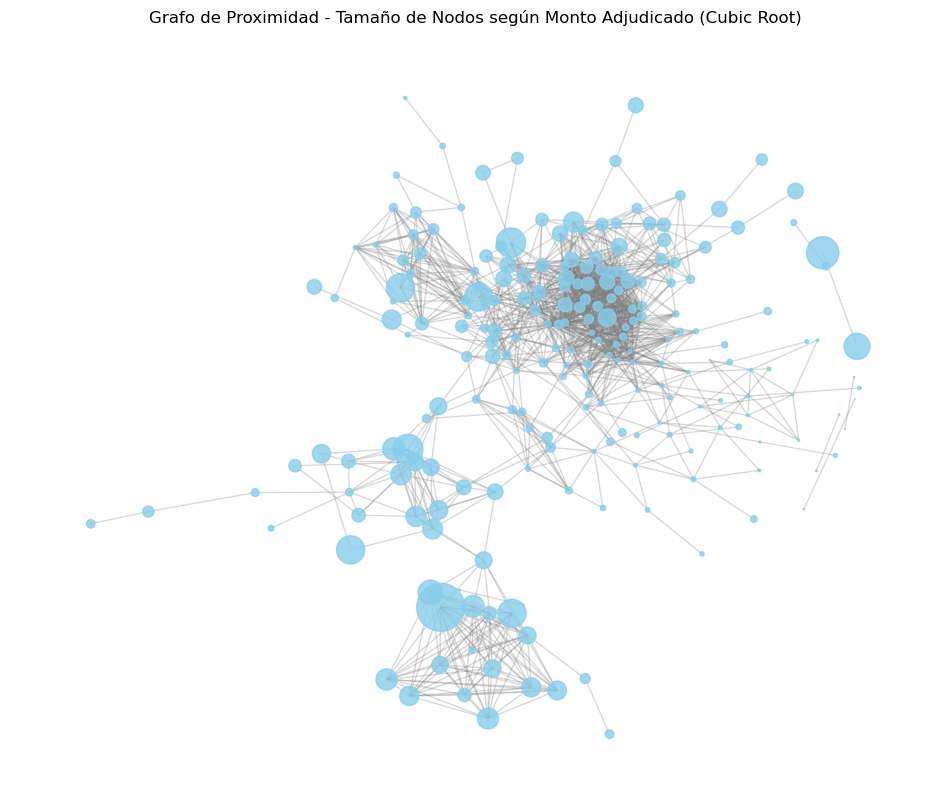

In [137]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Crear el grafo desde la matriz de proximidad
G = nx.from_pandas_adjacency(proximidad_df_2018)
G = nx.Graph(G)  # Asegurarse de que sea editable

# Filtrar aristas con pesos bajos para reducir la congestión
threshold_proximity = 0.2  # Ajusta según la densidad de tu grafo
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) < threshold_proximity]
G.remove_edges_from(edges_to_remove)

# **Eliminar loops (self-loops)**
G.remove_edges_from(nx.selfloop_edges(G))

# **Eliminar nodos aislados (sin conexiones)**
nodos_aislados = list(nx.isolates(G))
G.remove_nodes_from(nodos_aislados)

# Calcular el monto adjudicado por rubro desde 'lic_all_years_clean_2018_cleaned'
monto_adjudicado_por_rubro = df_2018.groupby('RubroN2')['TotalMontoAdjudicadoRubro'].sum()

# Normalizar y suavizar el tamaño de los nodos
monto_adjudicado_normalizado = monto_adjudicado_por_rubro / monto_adjudicado_por_rubro.max()

# Aplicar transformación cúbica raíz
monto_transformado = np.cbrt(monto_adjudicado_normalizado)

# Asignar tamaños de nodos al grafo
for nodo in G.nodes:
    G.nodes[nodo]['size'] = monto_transformado.get(nodo, 0.01) * 1200  # Escalar para un rango visible

# Configurar colores para los nodos (opcional)
node_colors = ['skyblue' for _ in G.nodes]

# Configurar tamaños de los nodos
node_sizes = [G.nodes[n]['size'] for n in G.nodes]

# Dibujar el grafo
plt.figure(figsize=(12, 10))
pos = nx.kamada_kawai_layout(G)  # Ajustar densidad del grafo
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
plt.title('Grafo de Proximidad - Tamaño de Nodos según Monto Adjudicado (Cubic Root)')
plt.axis('off')
plt.show()


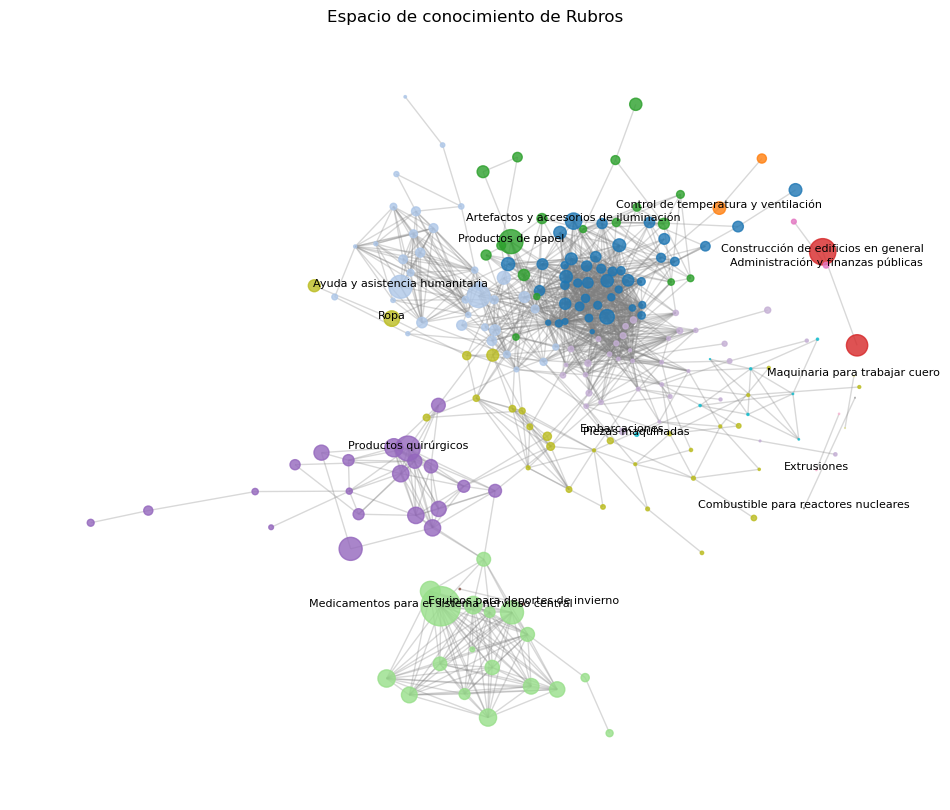

In [156]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from community import community_louvain

# Crear el grafo desde la matriz de proximidad
G = nx.from_pandas_adjacency(proximidad_df_2018)
G = nx.Graph(G)  # Asegurarse de que sea editable

# Filtrar aristas con pesos bajos para reducir la congestión
threshold_proximity = 0.2  # Ajusta según la densidad de tu grafo
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) < threshold_proximity]
G.remove_edges_from(edges_to_remove)

# **Eliminar loops (self-loops)**
G.remove_edges_from(nx.selfloop_edges(G))

# **Eliminar nodos aislados (sin conexiones)**
nodos_aislados = list(nx.isolates(G))
G.remove_nodes_from(nodos_aislados)

# Calcular el monto adjudicado por rubro desde 'lic_all_years_clean_2018_cleaned'
monto_adjudicado_por_rubro = df_2018.groupby('RubroN2')['TotalMontoAdjudicadoRubro'].sum()

# Normalizar y suavizar el tamaño de los nodos
monto_adjudicado_normalizado = monto_adjudicado_por_rubro / monto_adjudicado_por_rubro.max()

# Aplicar transformación cúbica raíz
monto_transformado = np.cbrt(monto_adjudicado_normalizado)

# Asignar tamaños de nodos al grafo
for nodo in G.nodes:
    G.nodes[nodo]['size'] = monto_transformado.get(nodo, 0.01) * 800  # Escalar para un rango visible

# **Aplicar Louvain para detectar comunidades**
partition = community_louvain.best_partition(G)  # Obtener partición de Louvain
nx.set_node_attributes(G, partition, 'community')  # Guardar comunidades en atributos del grafo

# Asignar colores a los nodos según las comunidades
unique_communities = set(partition.values())
color_map = plt.cm.tab20  # Usar un mapa de colores
community_colors = {community: color_map(i / len(unique_communities)) for i, community in enumerate(unique_communities)}

# Configurar colores y tamaños de los nodos
node_colors = [community_colors[partition[n]] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]

# Identificar rubros representativos por comunidad
representative_labels = {}
for community in unique_communities:
    nodes_in_community = [n for n in G.nodes if partition[n] == community]
    community_montos = {n: monto_adjudicado_por_rubro.get(n, 0) for n in nodes_in_community}
    top_rubros = sorted(community_montos, key=community_montos.get, reverse=True)[:1]  # Los 2 rubros más representativo por $
    for rubro in top_rubros:
        if community not in representative_labels:
            representative_labels[community] = []
        representative_labels[community].append(rubro)

# Dibujar el grafo
plt.figure(figsize=(12, 10))
pos = nx.kamada_kawai_layout(G)  # Ajustar densidad del grafo
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
plt.title('Espacio de conocimiento de Rubros')
plt.axis('off')

# Agregar nombres de los rubros representativos
for community, rubros in representative_labels.items():
    for rubro in rubros:
        if rubro in pos:  # Asegurarse de que el rubro esté en el grafo
            x, y = pos[rubro]
            plt.text(x, y, rubro, fontsize=8, ha='center', color='black')

# Mostrar el gráfico
plt.show()